# Tic tac toe

> Gradient Tree Boosting implementation test using the tic tac toe plays combinations data set

Imports

In [1]:
import math

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn import tree, preprocessing
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    RocCurveDisplay,
    precision_recall_curve,
    PrecisionRecallDisplay,
    f1_score,
)


Parameters

In [2]:
path_file_ds = './file/ds_tic-tac-toe.data'

# Data parsing parameters
class_positive_str, class_negative_str = 'positive', 'negative'
classes_names = [class_positive_str, class_negative_str]
class_positive, class_negative = 1, 0

play_x_str, play_o_str =  'x', 'o'
play_x, play_o = 1, 0

# Hyper parameters
n_folds = 5
test_size = .2
classes_threshold = .5

## Import data

In [3]:

# Parse input
features = [f'x{i + 1}' for i in range(9)]
col_y = 'y'

df = pd.read_csv(path_file_ds, header=None)
df.columns = features + [col_y]

def play_to_number(x: str):
    return play_x if x == play_x_str else play_o

def class_to_number(y: str):
    return class_positive if y == class_positive_str else class_negative

# Set working data
y = df[col_y].apply(np.vectorize(class_to_number))
X = df[features].apply(np.vectorize(play_to_number))

# See what we've got
n = len(y)
n_positive = np.sum(y == class_positive)
n_negative = np.sum(y == class_negative)

print(f"{n} samples; Positive cases: {n_positive}; Negative cases: {n_negative};")

958 samples; Positive cases: 626; Negative cases: 332;


## Algorithm Implementation

### Decision Tree

##### Entropy

In [4]:
def get_entropy(values: np.array, log_base: int = 2):
    
    unique_counts = np.bincount(values)
    probabilities = unique_counts / len(values)
    
    summation = 0
    for prob in probabilities:
        if prob > 0:
            summation += prob * math.log(prob, log_base)
    return -summation

##### Log of the Odds

In [5]:
class LogOfOdds():

    def __init__(self, class_pos: int, class_neg: int, values: np.array = np.array([])):
        
        self.class_pos = class_pos
        self.class_neg = class_neg
        
        if values.shape[0] > 0:
            self.from_distribution(values)
        else:
            self.value = 0

    @staticmethod
    def get_prob_from_log(log_odds: float):
        exp_log = math.exp(log_odds)
        return exp_log / (1 + exp_log)
    
    def from_values(self, values: np.array):
        aux = 1e-5
        n_pos = np.where(values == self.class_pos)[0].shape[0] + aux
        n_neg = np.where(values == self.class_neg)[0].shape[0] + aux
        self.value = math.log(n_pos / n_neg)
        return self

    def to_prob(self):
        return LogOfOdds.get_prob_from_log(self.value)

    def __str__(self):
        return str(self.value)


##### Tree

In [6]:
class Tree():

    def __init__(self, classifier: tree.DecisionTreeRegressor, log_odds: list):
        self.classifier = classifier
        self.log_odds = log_odds

    def predict(self, X: np.array) -> np.array:
        '''
            TODO: 2022-07-19 - ADD Description
        '''
        leaves = self.classifier.apply(X)
        leave_to_odds = np.vectorize(lambda leaf: self.log_odds[leaf])
        return leave_to_odds(leaves)


### Gradient Tree Boosting

In [7]:
class GradientTreeBoosting():
    '''
        TODO: 2022-07-19 - ADD Description
    '''

    def __init__(
        self, 
        max_depth: int = 4,
        max_trees: int = 10,
        max_features: int = None,
        learning_rate: float = 0.4,
        random_state: int = 0,
        epsilon: float = 0,
        class_pos: int = 1,
        class_neg: int = 0,
    ):

        self.epsilon = epsilon
        self.max_depth = max_depth
        self.max_trees = max_trees
        self.max_features = max_features
        self.learning_rate = learning_rate
        self.random_state = random_state
        
        self.class_pos = class_pos
        self.class_neg = class_neg
        
        self._trees = []
        self._log_odds = LogOfOdds(class_pos=self.class_pos, class_neg=self.class_neg)
        self._root_threshold = 0
        

    def fit(self, X: np.array, y: np.array):

        # Set root node value & initialize probabilities
        n = y.shape[0]
        root_log_odds = self._log_odds.from_values(y)
        self._root_threshold = root_log_odds.to_prob()
        
        probs = np.array([self._root_threshold] * n)
        log_odds = np.array([root_log_odds.value] * n)
        
        for _ in range(self.max_trees):

            # Creating a weak learner 
            dt = tree.DecisionTreeRegressor(
                max_depth=self.max_depth,
                max_features=self.max_features,
                random_state=self.random_state,
            )

            # Calculate new pseudo residuals
            residuals = y - probs
            is_optimum_tree = np.sum(np.fabs(residuals) < self.epsilon) == n
            if is_optimum_tree:
                break

            # Growing the tree on the residuals
            dt.fit(X, residuals)

            predictions = dt.predict(X)
            leaves = dt.apply(X)
            unique_leaves = np.unique(leaves)

            # Set normalized probability for all predictions in this leaf
            log_odds_norm = np.zeros( (n,) )
            leaves_log_odds = {}

            for leaf in unique_leaves:
                
                leaf_idx = np.where(leaves == leaf)
                leaf_residuals = residuals[leaf_idx]
                
                numerator = np.sum(leaf_residuals)
                denominator = np.sum([p * (1 - p) for p in log_odds[leaf_idx]])
                leaf_log_odds = numerator / denominator
                
                log_odds_norm[leaf_idx] = leaf_log_odds
                leaves_log_odds[leaf] = leaf_log_odds

            # Compute this model
            self._trees.append(Tree(classifier=dt, log_odds=leaves_log_odds))
            log_odds += self.learning_rate * log_odds_norm
            probs = np.vectorize(LogOfOdds.get_prob_from_log)(log_odds)

    def predict(self, X: np.array) -> np.array:
        
        n = X.shape[0]
        log_odds = np.array([self._root_threshold] * n)

        for dt in self._trees:
            log_odds += self.learning_rate * dt.predict(X=X)
        
        y_hat = np.vectorize(LogOfOdds.get_prob_from_log)(log_odds)
        return y_hat


## Evaluate

### Utils

#### Cross Validation

In [8]:
def cv_evaluate(params: dict, title: str = ''):

    classifier = GradientTreeBoosting(
        max_depth=params.get('max_depth'),
        max_trees=params.get('max_trees'),
        max_features=params.get('max_features'),
        learning_rate=params.get('learning_rate'),
        epsilon=params.get('epsilon'),
        random_state=random_state,
    )

    cv = StratifiedShuffleSplit(n_splits=n_folds, test_size=test_size, random_state=random_state)

    recalls = np.array([])
    accuracies = np.array([])
    precisions = np.array([])
    f1_scores_pos = np.array([])
    f1_scores_neg = np.array([])

    i = 0
    for train_index, test_index in cv.split(X, y):
        
        # Train & test
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
        n_test, n_train = len(test_index), len(train_index)

        classifier.fit(X=X_train, y=y_train)
        outputs = classifier.predict(X=X_test)
        y_hat = (outputs > classes_threshold).astype(int)

        # Evaluate
        accuracy = np.sum(y_hat == y_test) / n_test
        f1_pos, f1_neg = f1_score(y_test, y_hat, average=None)
        precision, recall, _ = precision_recall_curve(y_test, outputs, pos_label=1)

        # Display summary
        print('-' * 45)
        print(f"{title} Fold {i + 1}")
        print(f'{params}')
        print('')

        print(r"Train Samples: %d; Test Samples: %d" % (n_train, n_test))
        print(r"Accuracy: %.4f" % accuracy)
        print(r"Precision (average): %.4f" % precision.mean())
        print(r"Recall (average): %.4f" % recall.mean())
        print(r"F1 Score (positive): %.4f" % f1_pos)
        print(r"F1 Score (negative): %.4f" % f1_neg)
        print('')

        # Display confusion Matrix
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

        conf_matrix = confusion_matrix(y_test, y_hat)
        display_conf_matrix = ConfusionMatrixDisplay(conf_matrix)

        ax1.set_title('Confusion Matrix')

        plt.xticks(range(2), classes_names, fontsize=10)
        plt.yticks(range(2), classes_names, fontsize=10)
        plt.xlabel('Predicted', fontsize=12)
        plt.ylabel('Real', fontsize=12)
        display_conf_matrix.plot(ax=ax1)

        # Display ROC Curve
        fpr, tpr, _ = roc_curve(y_test, outputs, pos_label=1)
        display_roc = RocCurveDisplay(fpr=fpr, tpr=tpr)
        ax2.set_title('ROC Curve')
        display_roc.plot(ax=ax2)

        # Display Precision x Recall Curve
        display_precision_recall = PrecisionRecallDisplay(precision=precision, recall=recall)
        ax3.set_title('Precision vs. Recall Curve')
        display_precision_recall.plot(ax=ax3)
        plt.show()

        # Compute this fold
        recalls = np.append(recalls, recall)
        accuracies = np.append(accuracies, accuracy)
        precisions = np.append(precisions, precision)
        f1_scores_pos = np.append(f1_scores_pos, f1_pos)
        f1_scores_neg = np.append(f1_scores_neg, f1_neg)
        i += 1

#### Grid Search

In [9]:

def grid_search_evaluate(grid_params: dict, i: int = 1) -> None:

    has_more_combinations = False
    
    # Build combination of parameter values to cross validate
    cv_params = {}
    for key, values in grid_params.items():
        
        value = values[0]
        cv_params[key] = value
        
        # Remove tested value from the next grid search experiments
        if not has_more_combinations and len(values) > 1:
            has_more_combinations = True
            grid_params[key] = [v for v in values if v != value]

    # Cross validate this combination
    cv_evaluate(params=cv_params, title=f'Grid Search {i}')
    
    # Keep on searching
    if has_more_combinations:
        grid_search_evaluate(grid_params, i + 1)


### Evaluate

---------------------------------------------
Grid Search 1 Fold 1
{'max_depth': 8, 'max_trees': 10, 'max_features': 3, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.6510
Precision (average): 0.9984
Recall (average): 0.5484
F1 Score (positive): 0.0000
F1 Score (negative): 0.7886



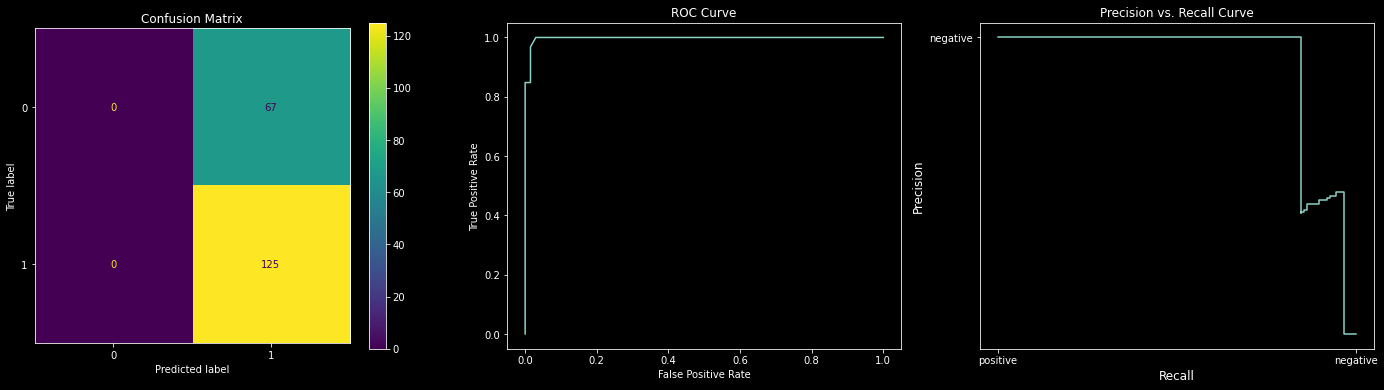

---------------------------------------------
Grid Search 1 Fold 2
{'max_depth': 8, 'max_trees': 10, 'max_features': 3, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.6510
Precision (average): 0.9989
Recall (average): 0.5806
F1 Score (positive): 0.0000
F1 Score (negative): 0.7886



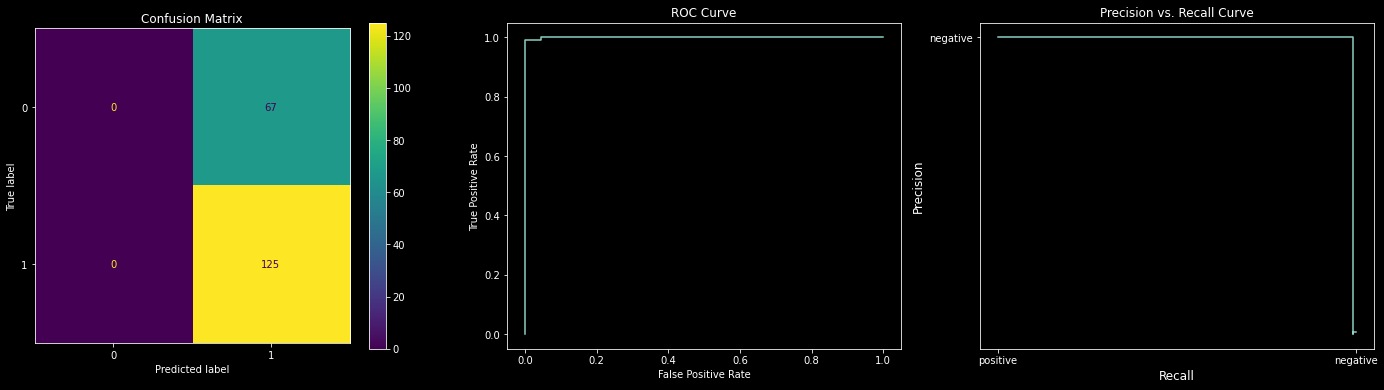

---------------------------------------------
Grid Search 1 Fold 3
{'max_depth': 8, 'max_trees': 10, 'max_features': 3, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.6510
Precision (average): 1.0000
Recall (average): 0.5525
F1 Score (positive): 0.0000
F1 Score (negative): 0.7886



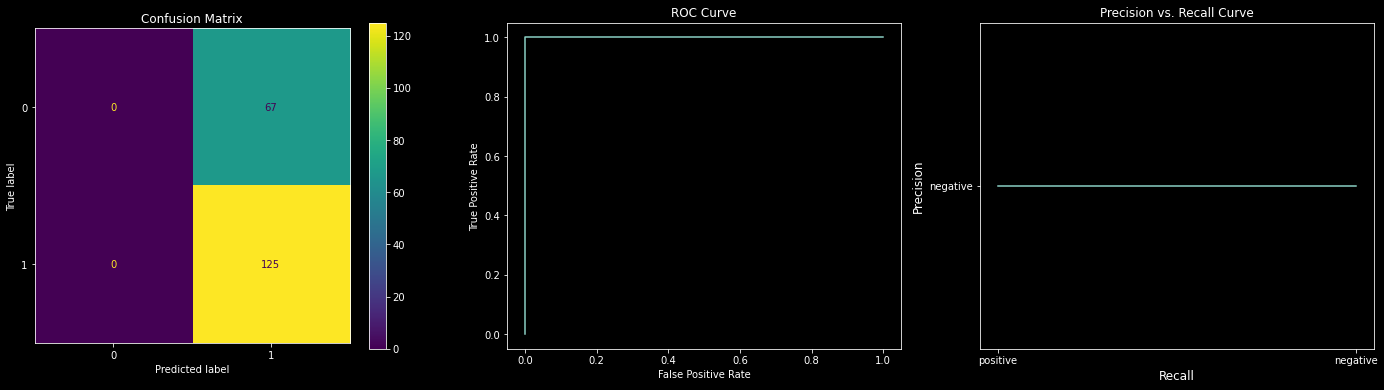

---------------------------------------------
Grid Search 1 Fold 4
{'max_depth': 8, 'max_trees': 10, 'max_features': 3, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.6510
Precision (average): 1.0000
Recall (average): 0.5526
F1 Score (positive): 0.0000
F1 Score (negative): 0.7886



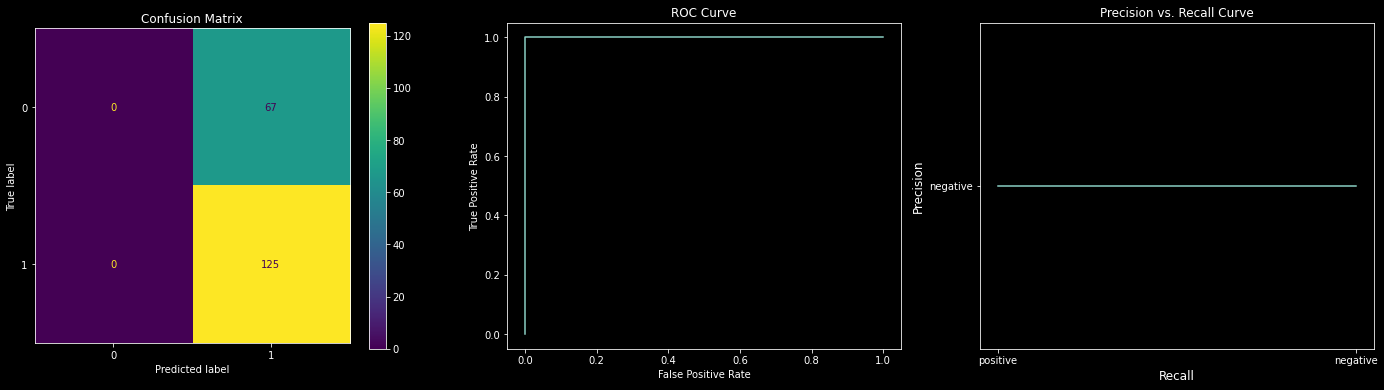

---------------------------------------------
Grid Search 1 Fold 5
{'max_depth': 8, 'max_trees': 10, 'max_features': 3, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.6510
Precision (average): 1.0000
Recall (average): 0.5676
F1 Score (positive): 0.0000
F1 Score (negative): 0.7886



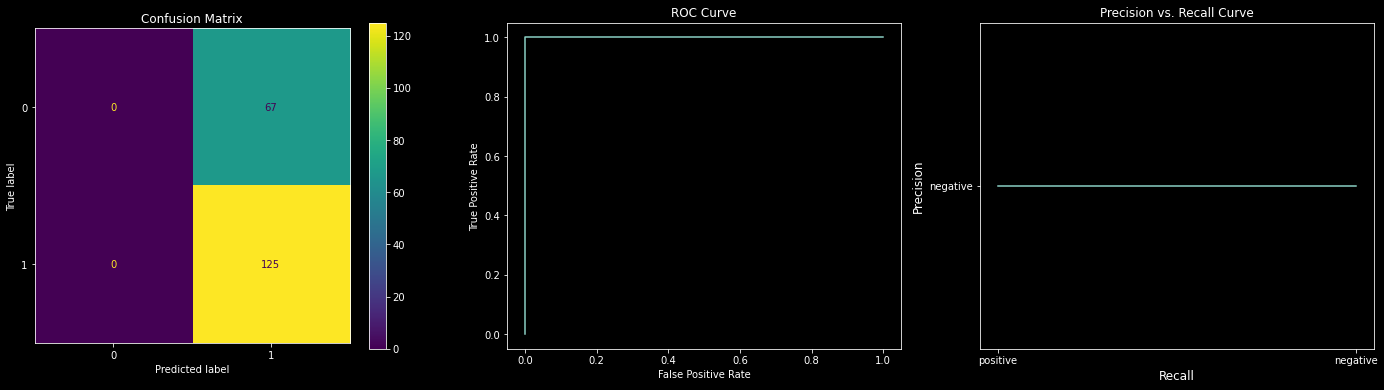

---------------------------------------------
Grid Search 2 Fold 1
{'max_depth': 16, 'max_trees': 10, 'max_features': 3, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.6510
Precision (average): 1.0000
Recall (average): 0.7904
F1 Score (positive): 0.0000
F1 Score (negative): 0.7886



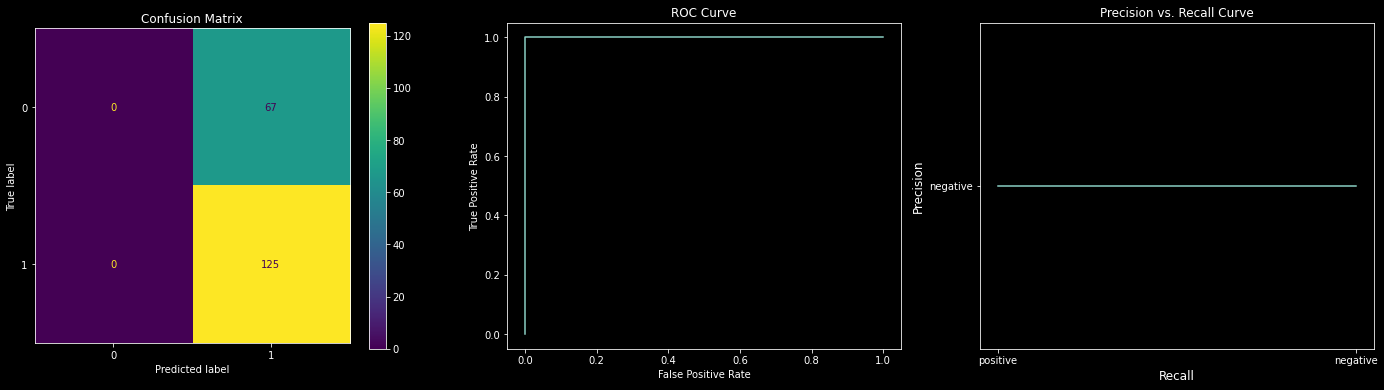

---------------------------------------------
Grid Search 2 Fold 2
{'max_depth': 16, 'max_trees': 10, 'max_features': 3, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.6510
Precision (average): 1.0000
Recall (average): 0.8825
F1 Score (positive): 0.0000
F1 Score (negative): 0.7886



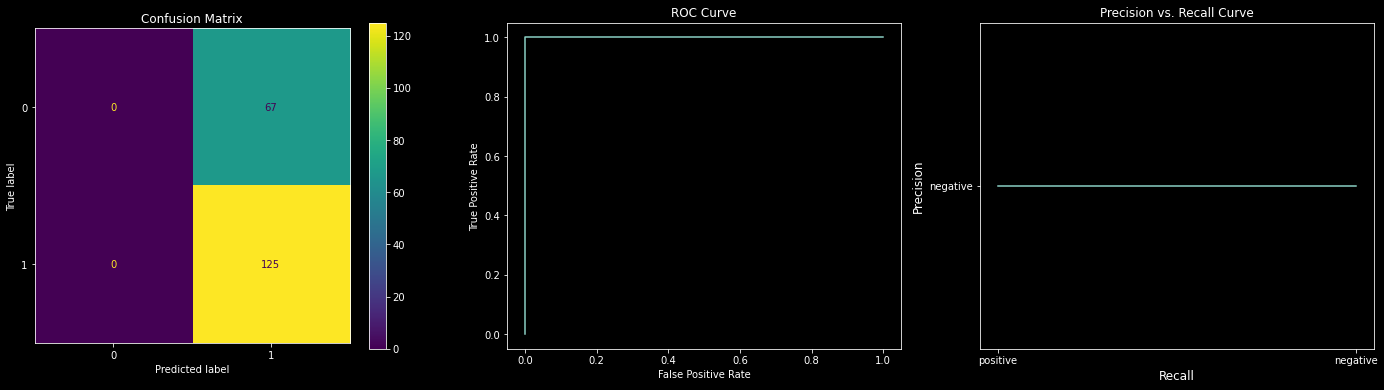

---------------------------------------------
Grid Search 2 Fold 3
{'max_depth': 16, 'max_trees': 10, 'max_features': 3, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.6510
Precision (average): 1.0000
Recall (average): 0.8830
F1 Score (positive): 0.0000
F1 Score (negative): 0.7886



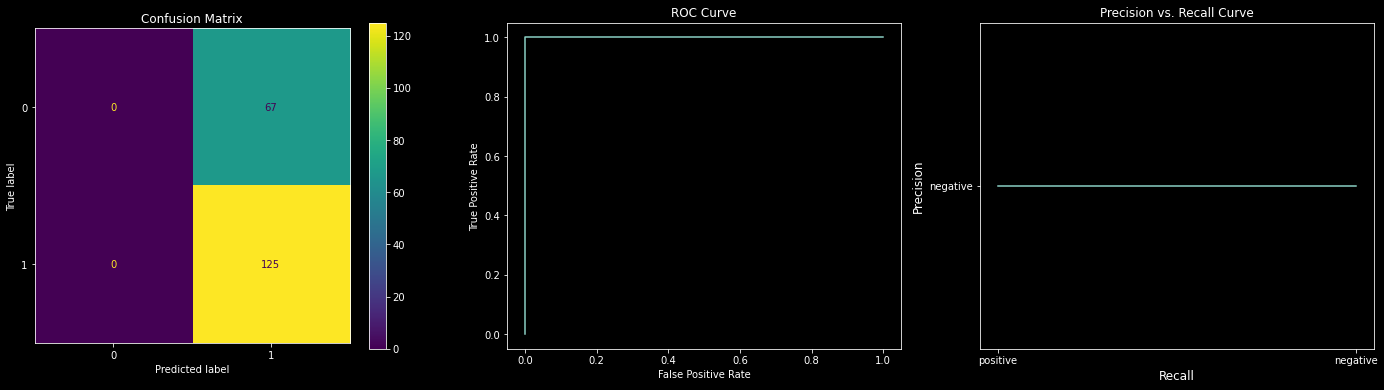

---------------------------------------------
Grid Search 2 Fold 4
{'max_depth': 16, 'max_trees': 10, 'max_features': 3, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.6510
Precision (average): 1.0000
Recall (average): 0.8800
F1 Score (positive): 0.0000
F1 Score (negative): 0.7886



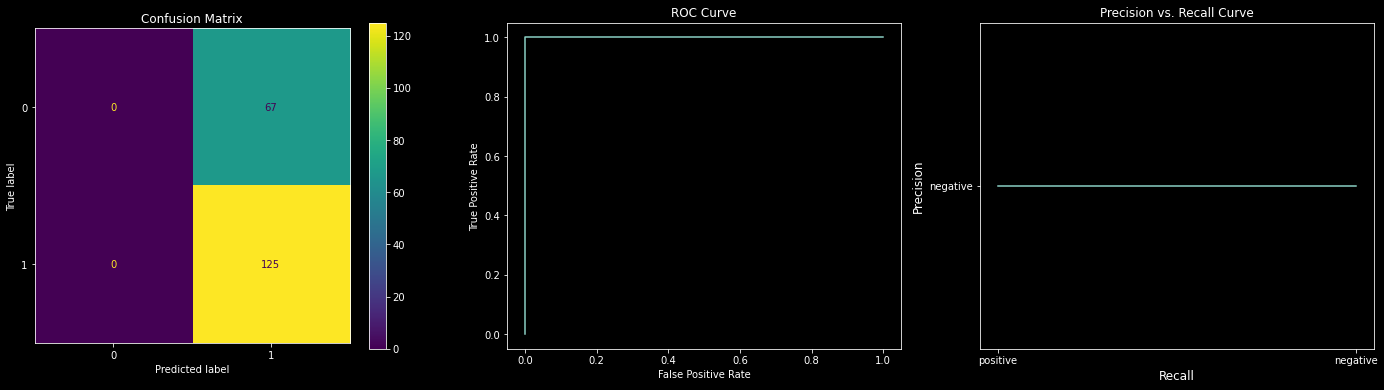

---------------------------------------------
Grid Search 2 Fold 5
{'max_depth': 16, 'max_trees': 10, 'max_features': 3, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.6510
Precision (average): 1.0000
Recall (average): 0.8829
F1 Score (positive): 0.0000
F1 Score (negative): 0.7886



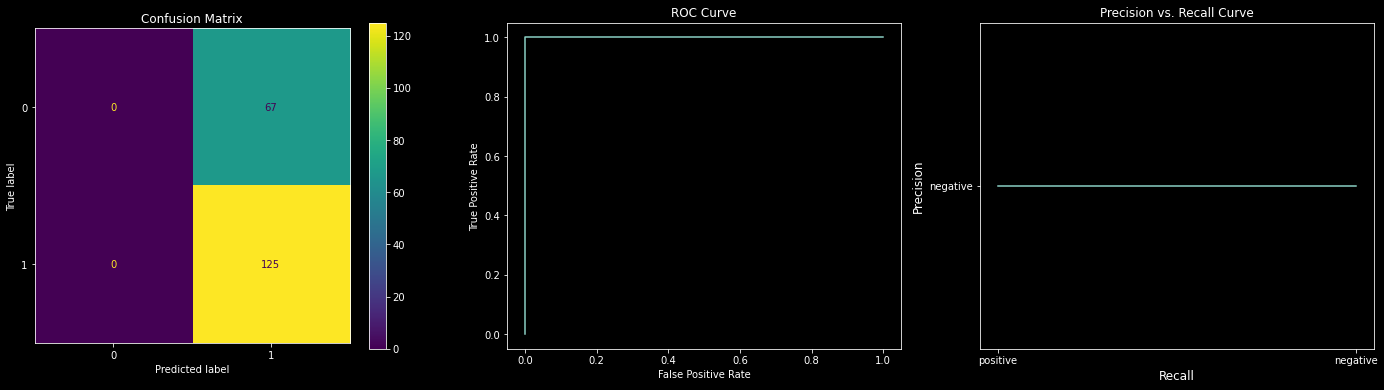

---------------------------------------------
Grid Search 3 Fold 1
{'max_depth': 24, 'max_trees': 10, 'max_features': 3, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.6510
Precision (average): 1.0000
Recall (average): 0.7904
F1 Score (positive): 0.0000
F1 Score (negative): 0.7886



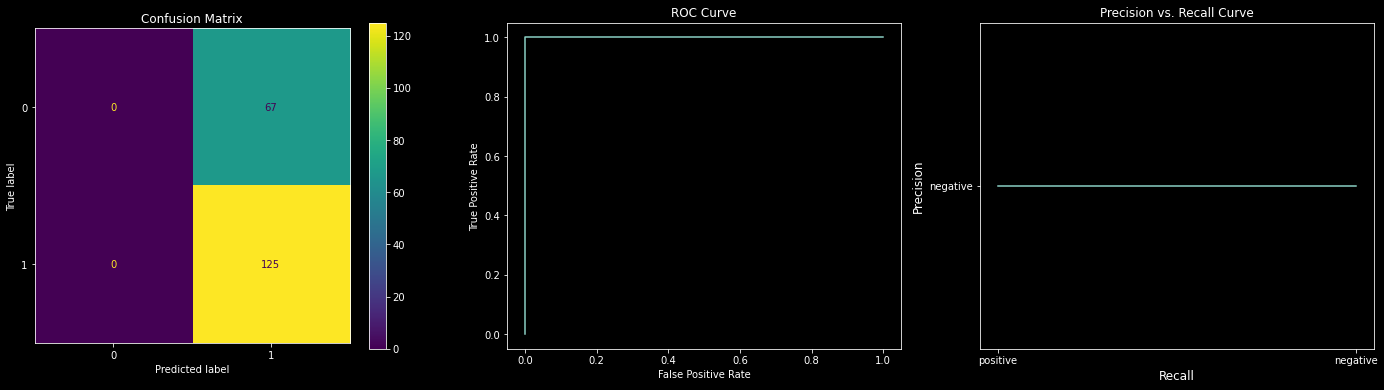

---------------------------------------------
Grid Search 3 Fold 2
{'max_depth': 24, 'max_trees': 10, 'max_features': 3, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.6510
Precision (average): 1.0000
Recall (average): 0.8825
F1 Score (positive): 0.0000
F1 Score (negative): 0.7886



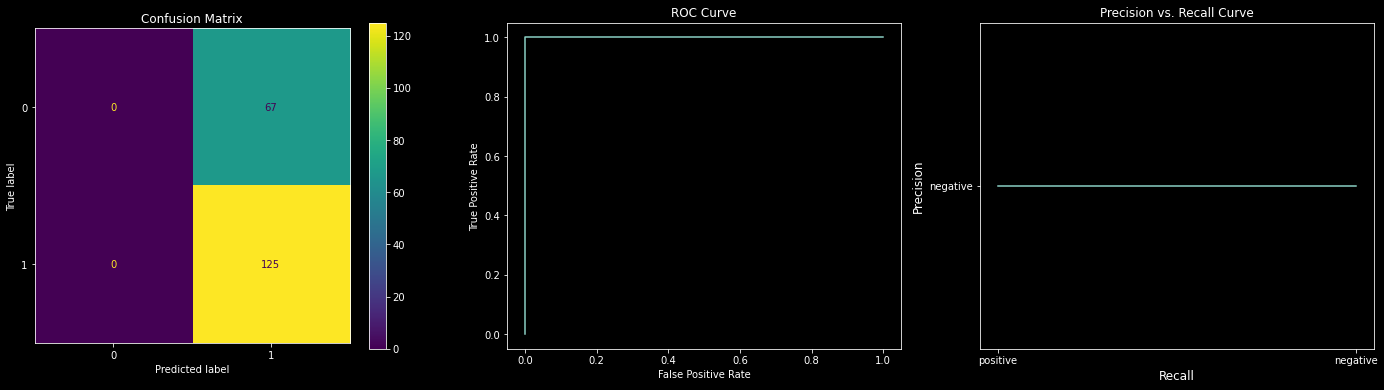

---------------------------------------------
Grid Search 3 Fold 3
{'max_depth': 24, 'max_trees': 10, 'max_features': 3, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.6510
Precision (average): 1.0000
Recall (average): 0.8830
F1 Score (positive): 0.0000
F1 Score (negative): 0.7886



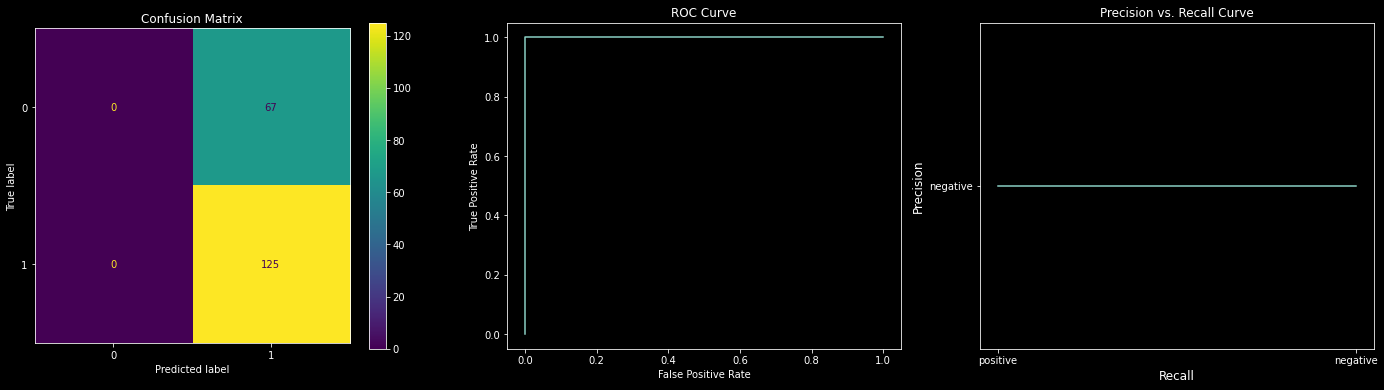

---------------------------------------------
Grid Search 3 Fold 4
{'max_depth': 24, 'max_trees': 10, 'max_features': 3, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.6510
Precision (average): 1.0000
Recall (average): 0.8800
F1 Score (positive): 0.0000
F1 Score (negative): 0.7886



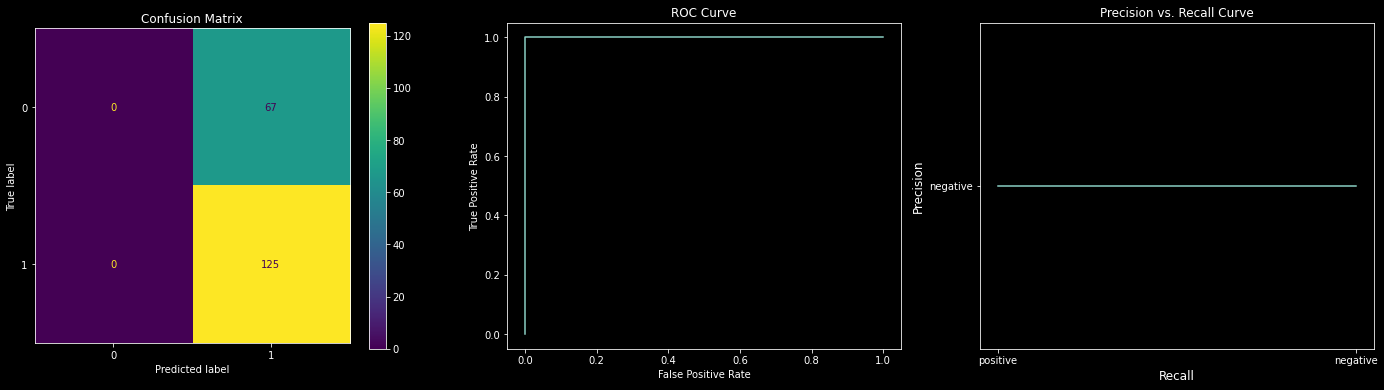

---------------------------------------------
Grid Search 3 Fold 5
{'max_depth': 24, 'max_trees': 10, 'max_features': 3, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.6510
Precision (average): 1.0000
Recall (average): 0.8829
F1 Score (positive): 0.0000
F1 Score (negative): 0.7886



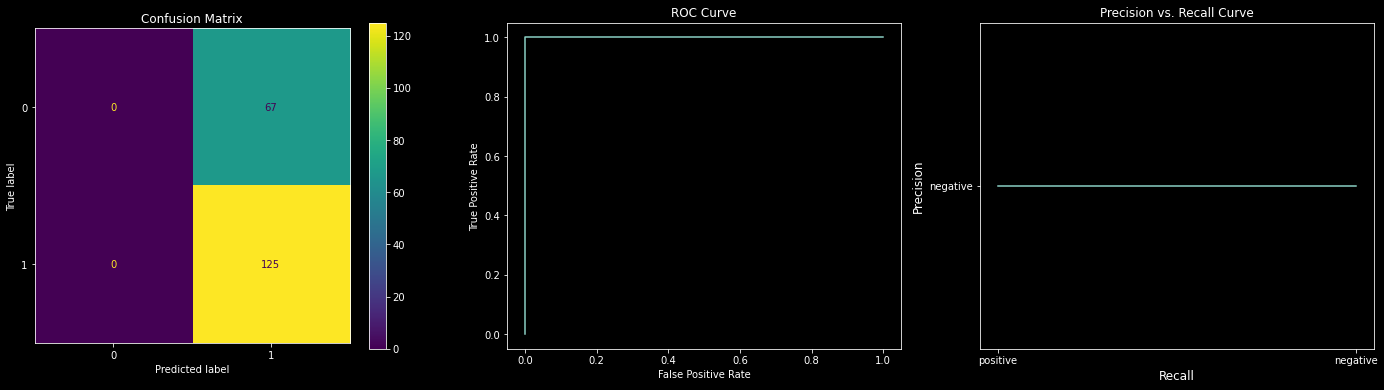

---------------------------------------------
Grid Search 4 Fold 1
{'max_depth': 32, 'max_trees': 10, 'max_features': 3, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.6510
Precision (average): 1.0000
Recall (average): 0.7904
F1 Score (positive): 0.0000
F1 Score (negative): 0.7886



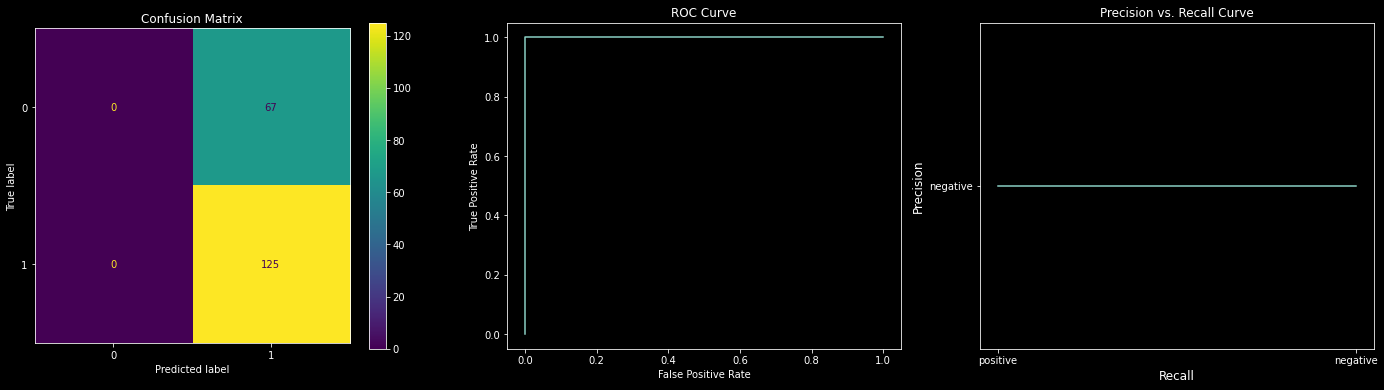

---------------------------------------------
Grid Search 4 Fold 2
{'max_depth': 32, 'max_trees': 10, 'max_features': 3, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.6510
Precision (average): 1.0000
Recall (average): 0.8825
F1 Score (positive): 0.0000
F1 Score (negative): 0.7886



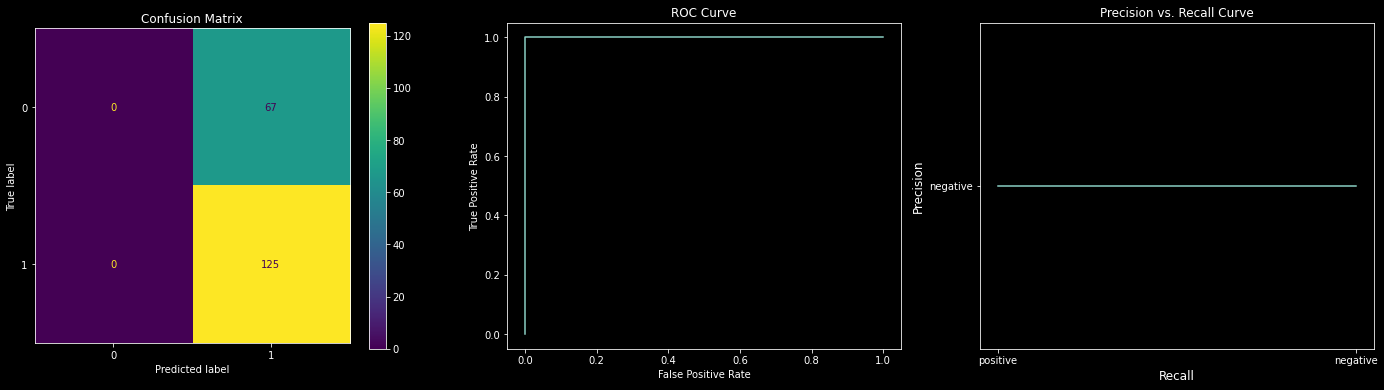

---------------------------------------------
Grid Search 4 Fold 3
{'max_depth': 32, 'max_trees': 10, 'max_features': 3, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.6510
Precision (average): 1.0000
Recall (average): 0.8830
F1 Score (positive): 0.0000
F1 Score (negative): 0.7886



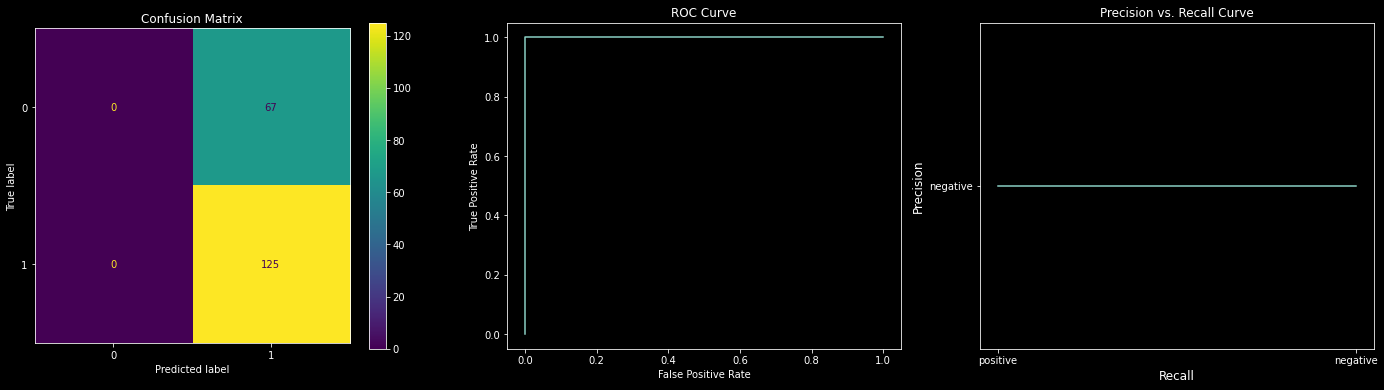

---------------------------------------------
Grid Search 4 Fold 4
{'max_depth': 32, 'max_trees': 10, 'max_features': 3, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.6510
Precision (average): 1.0000
Recall (average): 0.8800
F1 Score (positive): 0.0000
F1 Score (negative): 0.7886



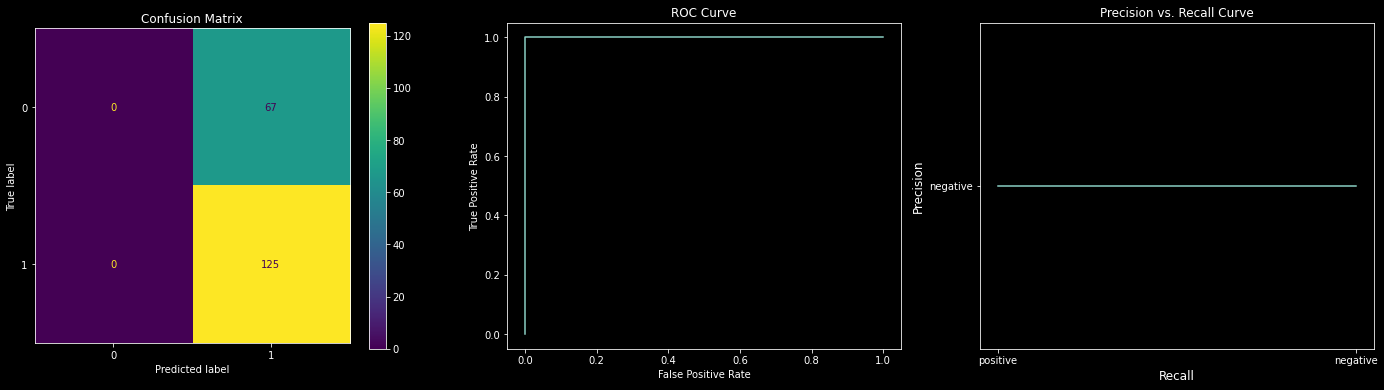

---------------------------------------------
Grid Search 4 Fold 5
{'max_depth': 32, 'max_trees': 10, 'max_features': 3, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.6510
Precision (average): 1.0000
Recall (average): 0.8829
F1 Score (positive): 0.0000
F1 Score (negative): 0.7886



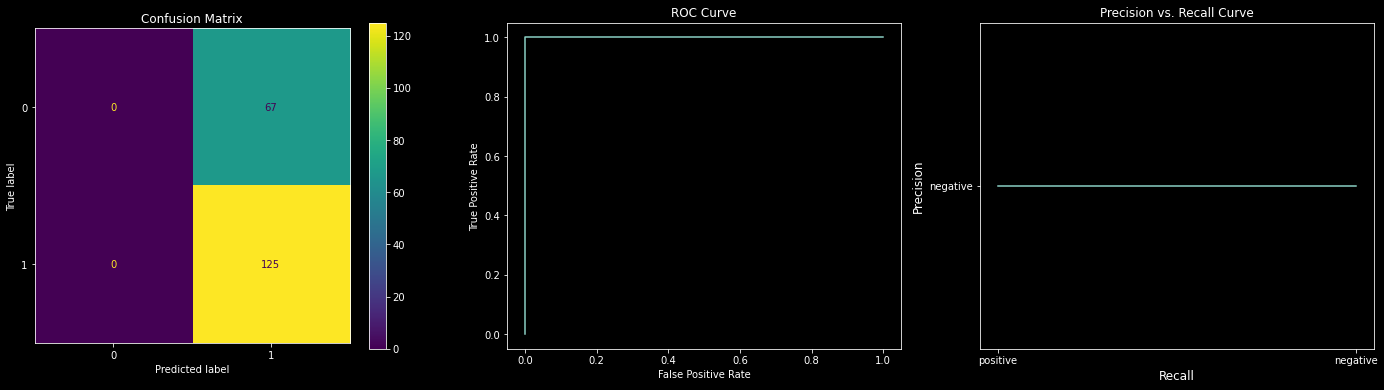

---------------------------------------------
Grid Search 5 Fold 1
{'max_depth': 32, 'max_trees': 50, 'max_features': 3, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.6510
Precision (average): 1.0000
Recall (average): 0.8200
F1 Score (positive): 0.0000
F1 Score (negative): 0.7886



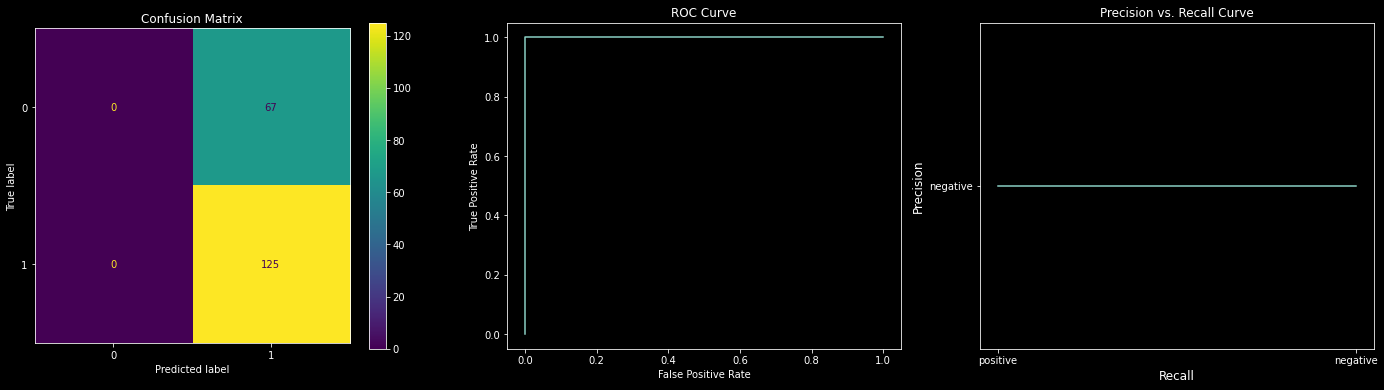

---------------------------------------------
Grid Search 5 Fold 2
{'max_depth': 32, 'max_trees': 50, 'max_features': 3, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.6510
Precision (average): 1.0000
Recall (average): 0.8840
F1 Score (positive): 0.0000
F1 Score (negative): 0.7886



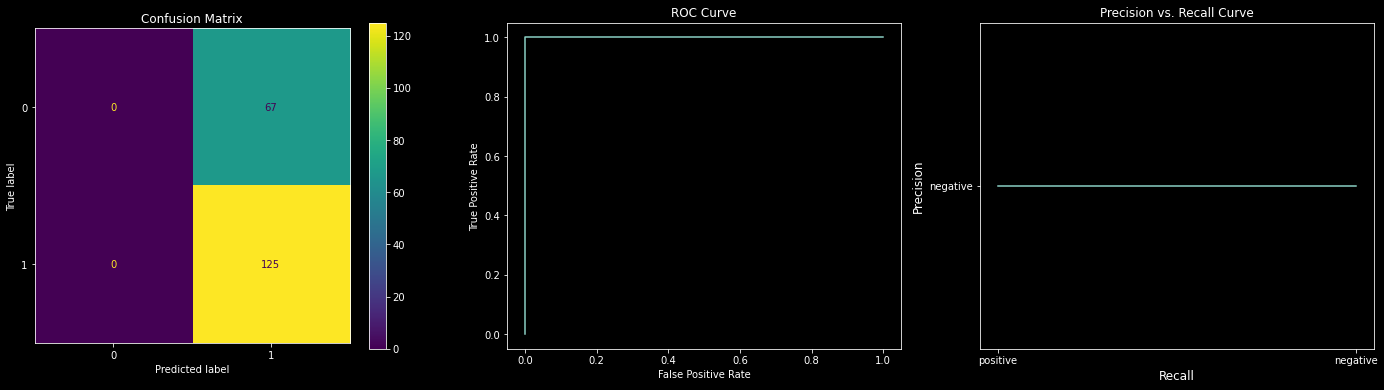

---------------------------------------------
Grid Search 5 Fold 3
{'max_depth': 32, 'max_trees': 50, 'max_features': 3, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.6510
Precision (average): 1.0000
Recall (average): 0.8840
F1 Score (positive): 0.0000
F1 Score (negative): 0.7886



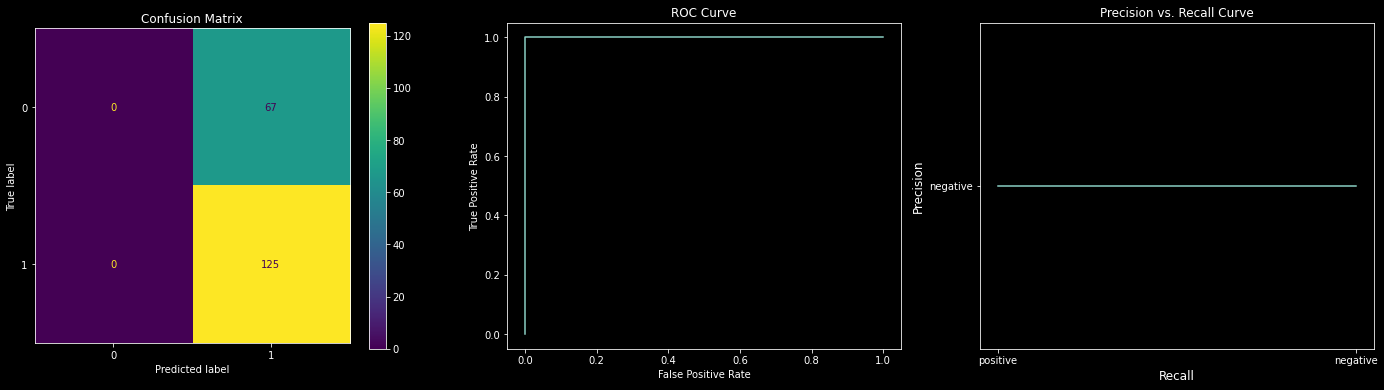

---------------------------------------------
Grid Search 5 Fold 4
{'max_depth': 32, 'max_trees': 50, 'max_features': 3, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.6510
Precision (average): 1.0000
Recall (average): 0.8800
F1 Score (positive): 0.0000
F1 Score (negative): 0.7886



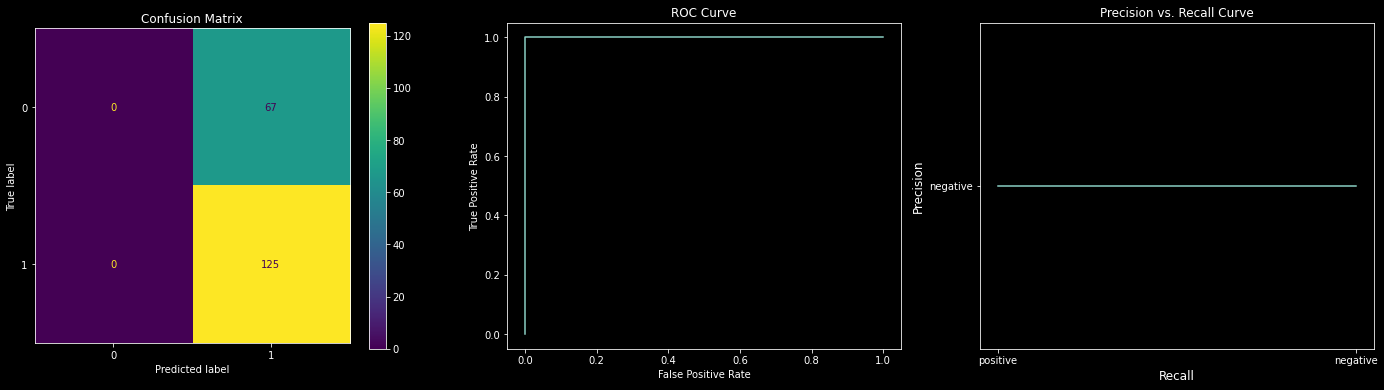

---------------------------------------------
Grid Search 5 Fold 5
{'max_depth': 32, 'max_trees': 50, 'max_features': 3, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.9323
Precision (average): 1.0000
Recall (average): 0.8829
F1 Score (positive): 0.8926
F1 Score (negative): 0.9506



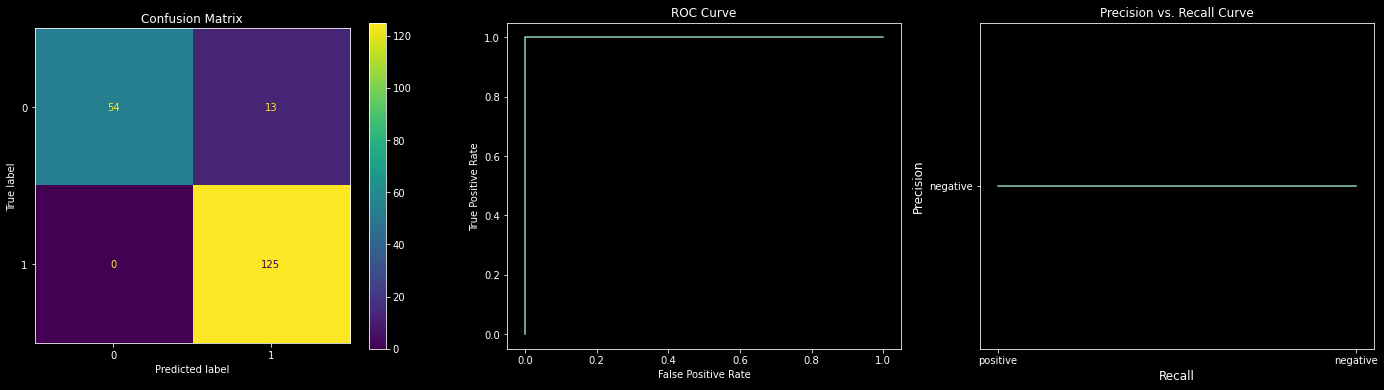

---------------------------------------------
Grid Search 6 Fold 1
{'max_depth': 32, 'max_trees': 100, 'max_features': 3, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.6510
Precision (average): 1.0000
Recall (average): 0.8400
F1 Score (positive): 0.0000
F1 Score (negative): 0.7886



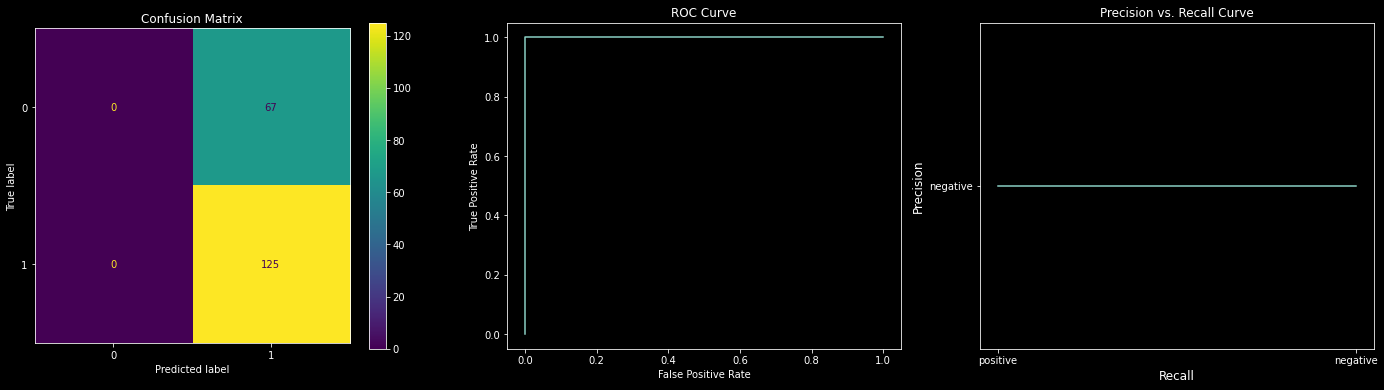

---------------------------------------------
Grid Search 6 Fold 2
{'max_depth': 32, 'max_trees': 100, 'max_features': 3, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.6510
Precision (average): 1.0000
Recall (average): 0.8840
F1 Score (positive): 0.0000
F1 Score (negative): 0.7886



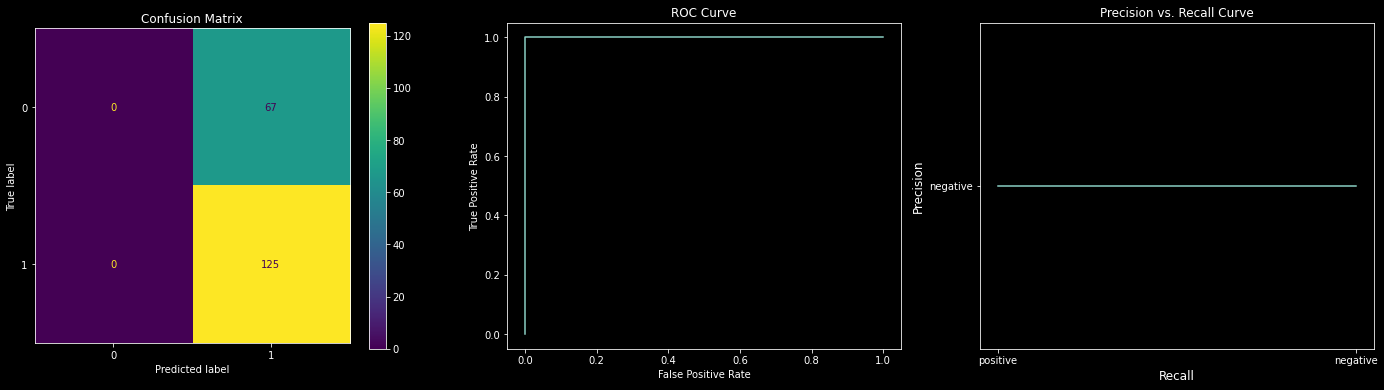

---------------------------------------------
Grid Search 6 Fold 3
{'max_depth': 32, 'max_trees': 100, 'max_features': 3, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.9792
Precision (average): 1.0000
Recall (average): 0.8232
F1 Score (positive): 0.9692
F1 Score (negative): 0.9843



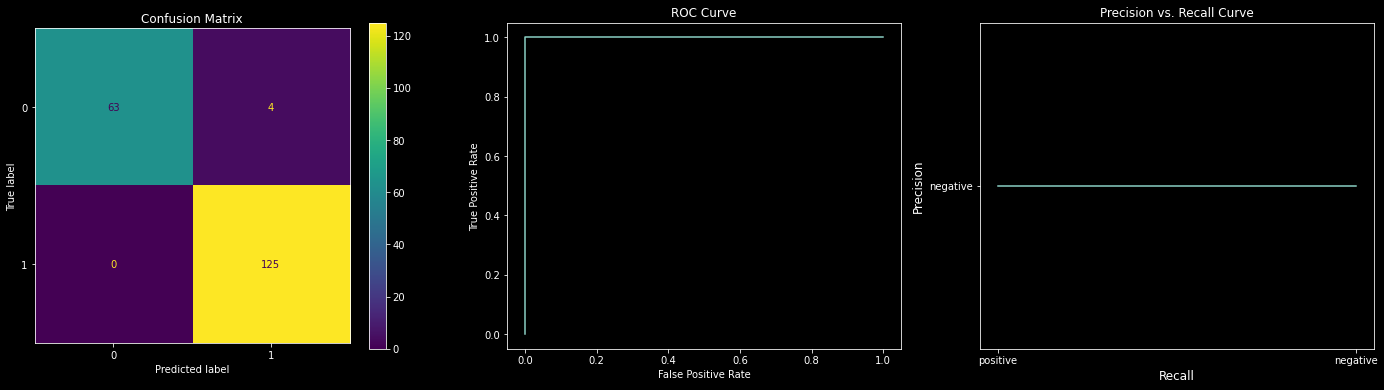

---------------------------------------------
Grid Search 6 Fold 4
{'max_depth': 32, 'max_trees': 100, 'max_features': 3, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.9948
Precision (average): 1.0000
Recall (average): 0.8800
F1 Score (positive): 0.9925
F1 Score (negative): 0.9960



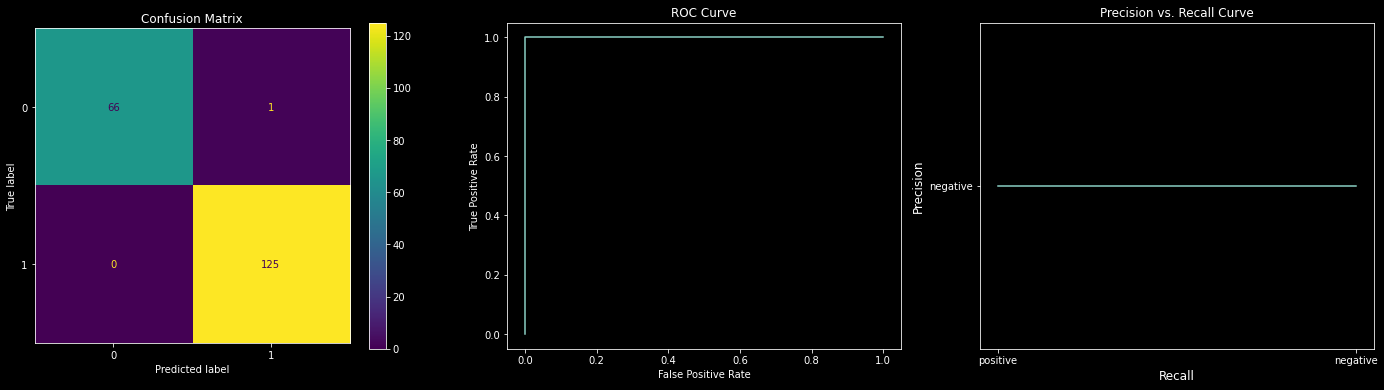

---------------------------------------------
Grid Search 6 Fold 5
{'max_depth': 32, 'max_trees': 100, 'max_features': 3, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 1.0000
Precision (average): 1.0000
Recall (average): 0.8572
F1 Score (positive): 1.0000
F1 Score (negative): 1.0000



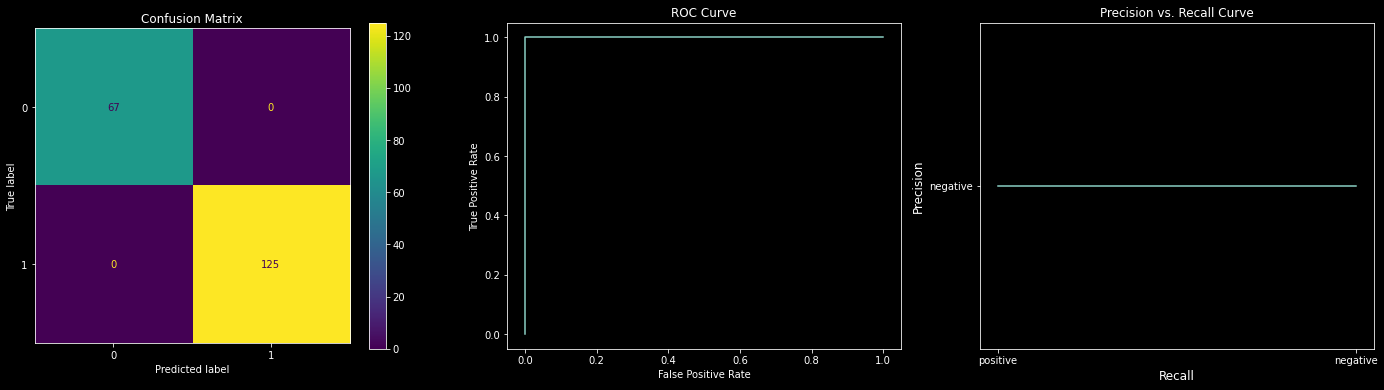

---------------------------------------------
Grid Search 7 Fold 1
{'max_depth': 32, 'max_trees': 150, 'max_features': 3, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.6510
Precision (average): 1.0000
Recall (average): 0.8400
F1 Score (positive): 0.0000
F1 Score (negative): 0.7886



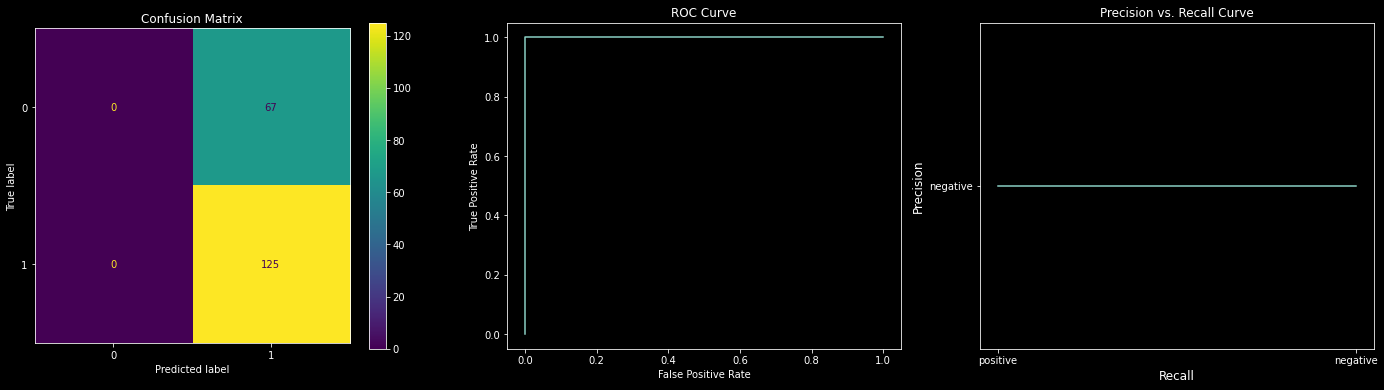

---------------------------------------------
Grid Search 7 Fold 2
{'max_depth': 32, 'max_trees': 150, 'max_features': 3, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.9844
Precision (average): 1.0000
Recall (average): 0.8840
F1 Score (positive): 0.9771
F1 Score (negative): 0.9881



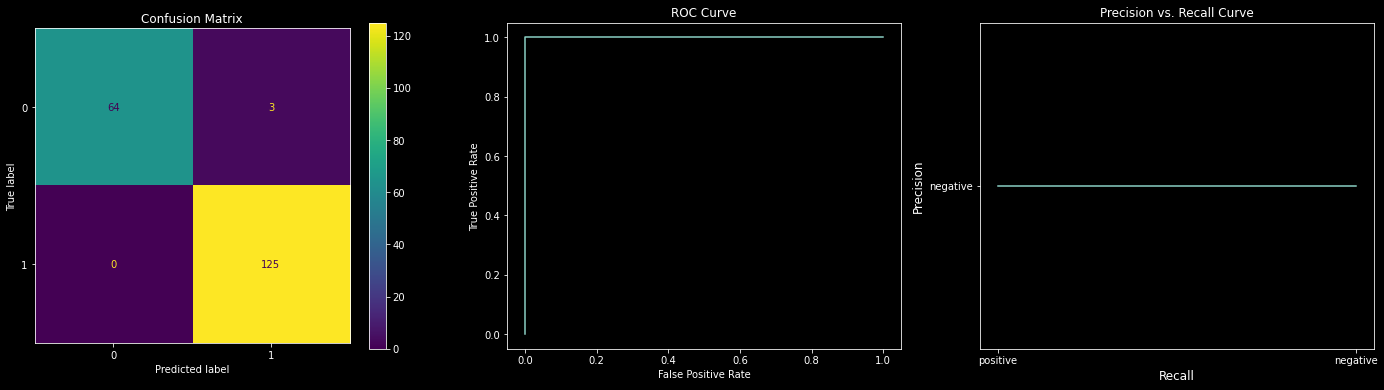

---------------------------------------------
Grid Search 7 Fold 3
{'max_depth': 32, 'max_trees': 150, 'max_features': 3, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.9948
Precision (average): 1.0000
Recall (average): 0.8493
F1 Score (positive): 0.9925
F1 Score (negative): 0.9960



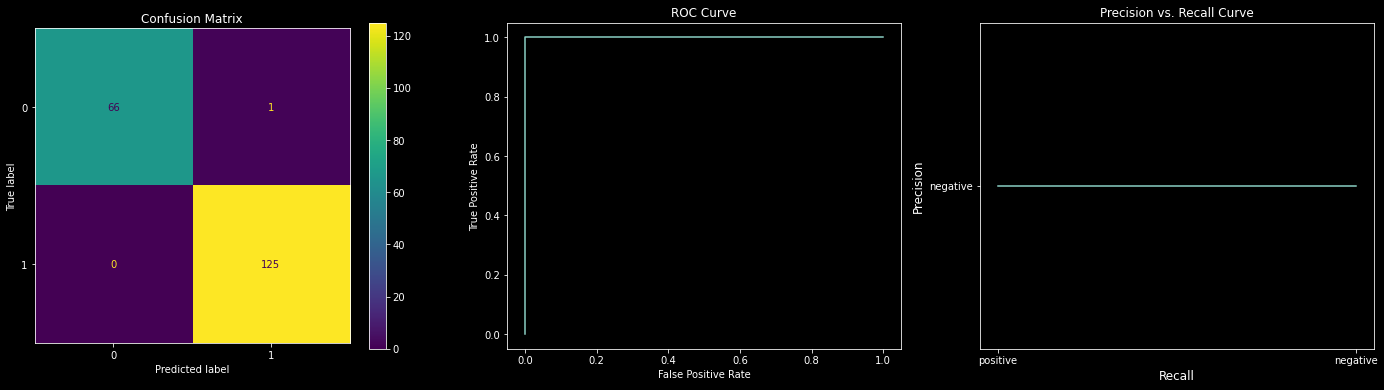

---------------------------------------------
Grid Search 7 Fold 4
{'max_depth': 32, 'max_trees': 150, 'max_features': 3, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.9948
Precision (average): 1.0000
Recall (average): 0.8351
F1 Score (positive): 0.9925
F1 Score (negative): 0.9960



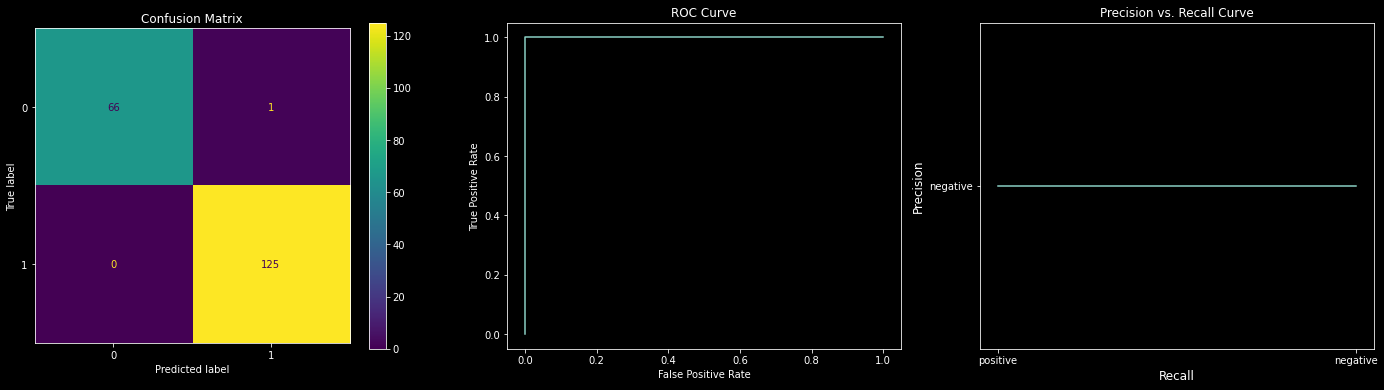

---------------------------------------------
Grid Search 7 Fold 5
{'max_depth': 32, 'max_trees': 150, 'max_features': 3, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 1.0000
Precision (average): 1.0000
Recall (average): 0.8536
F1 Score (positive): 1.0000
F1 Score (negative): 1.0000



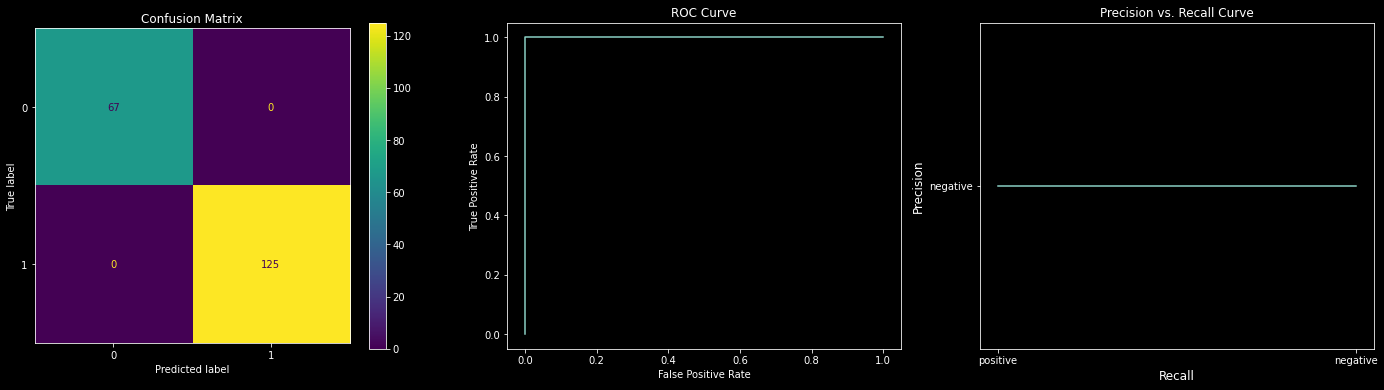

---------------------------------------------
Grid Search 8 Fold 1
{'max_depth': 32, 'max_trees': 150, 'max_features': 6, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.6510
Precision (average): 1.0000
Recall (average): 0.8200
F1 Score (positive): 0.0000
F1 Score (negative): 0.7886



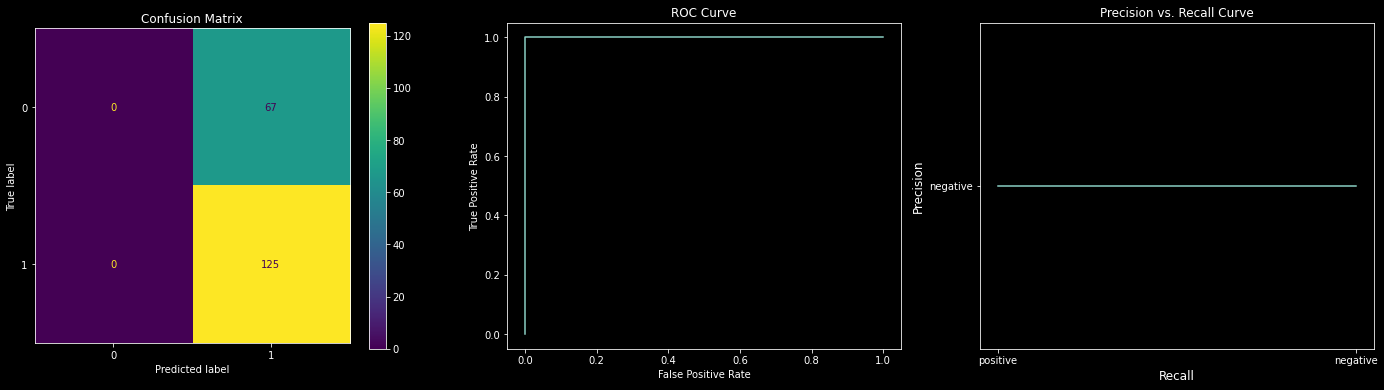

---------------------------------------------
Grid Search 8 Fold 2
{'max_depth': 32, 'max_trees': 150, 'max_features': 6, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.9740
Precision (average): 1.0000
Recall (average): 0.8825
F1 Score (positive): 0.9612
F1 Score (negative): 0.9804



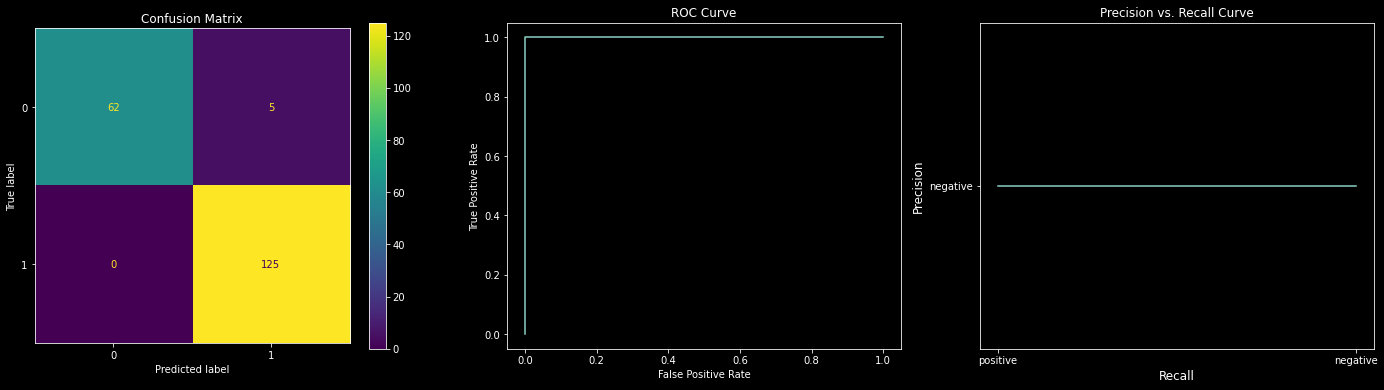

---------------------------------------------
Grid Search 8 Fold 3
{'max_depth': 32, 'max_trees': 150, 'max_features': 6, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.9948
Precision (average): 1.0000
Recall (average): 0.8531
F1 Score (positive): 0.9925
F1 Score (negative): 0.9960



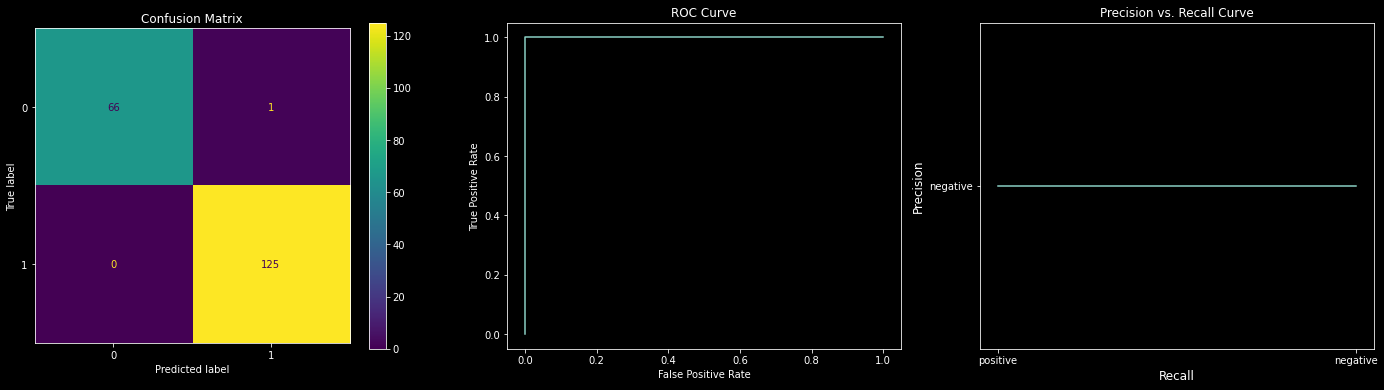

---------------------------------------------
Grid Search 8 Fold 4
{'max_depth': 32, 'max_trees': 150, 'max_features': 6, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 1.0000
Precision (average): 1.0000
Recall (average): 0.8474
F1 Score (positive): 1.0000
F1 Score (negative): 1.0000



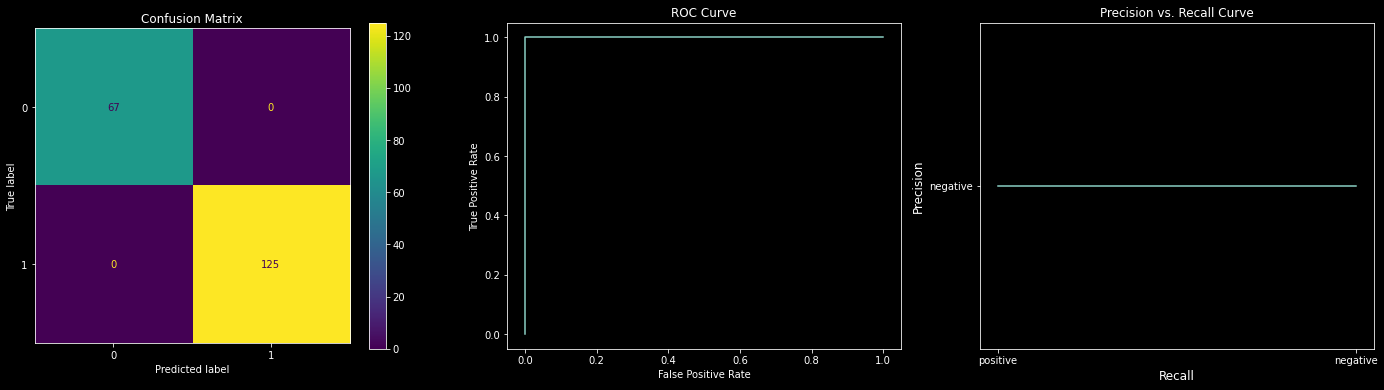

---------------------------------------------
Grid Search 8 Fold 5
{'max_depth': 32, 'max_trees': 150, 'max_features': 6, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 1.0000
Precision (average): 1.0000
Recall (average): 0.8644
F1 Score (positive): 1.0000
F1 Score (negative): 1.0000



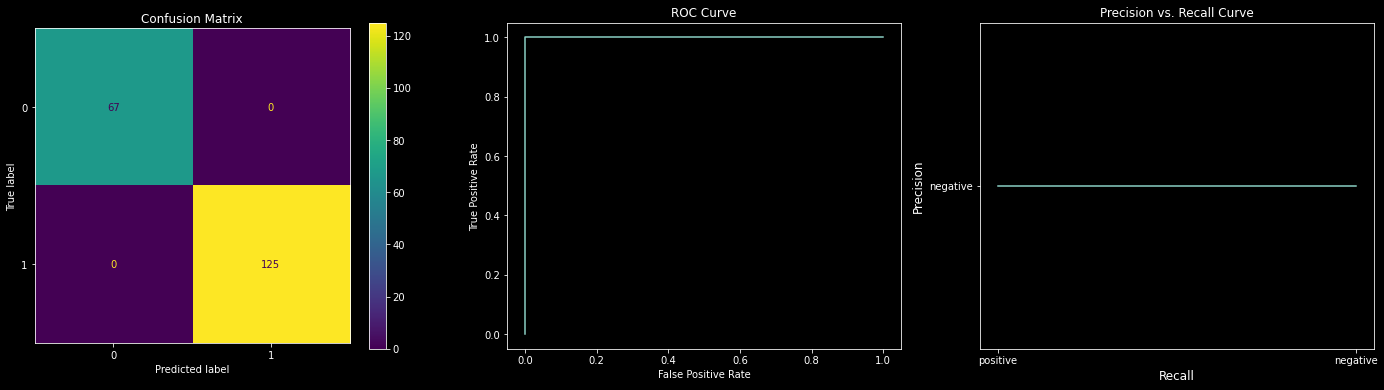

---------------------------------------------
Grid Search 9 Fold 1
{'max_depth': 32, 'max_trees': 150, 'max_features': None, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.6510
Precision (average): 0.9068
Recall (average): 0.7460
F1 Score (positive): 0.0000
F1 Score (negative): 0.7886



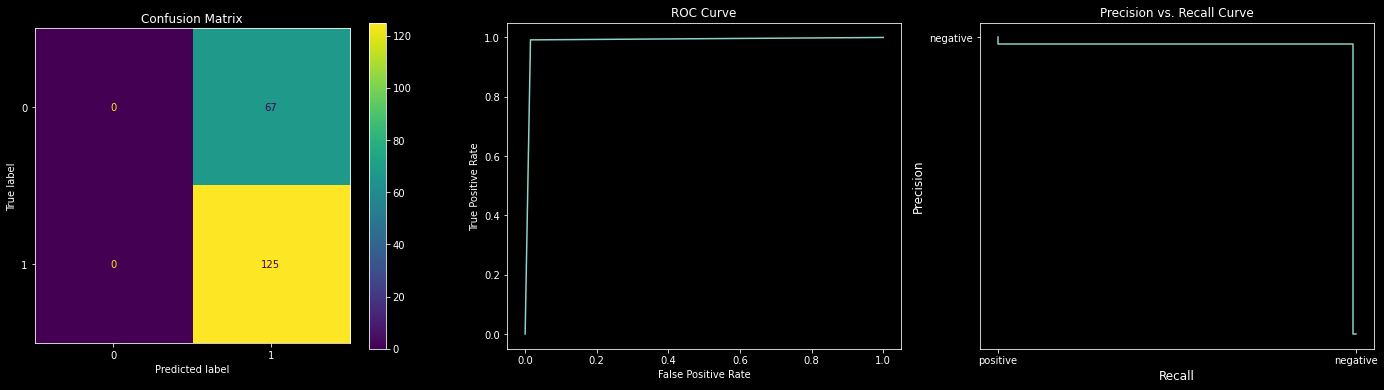

---------------------------------------------
Grid Search 9 Fold 2
{'max_depth': 32, 'max_trees': 150, 'max_features': None, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.9844
Precision (average): 1.0000
Recall (average): 0.6640
F1 Score (positive): 0.9771
F1 Score (negative): 0.9881



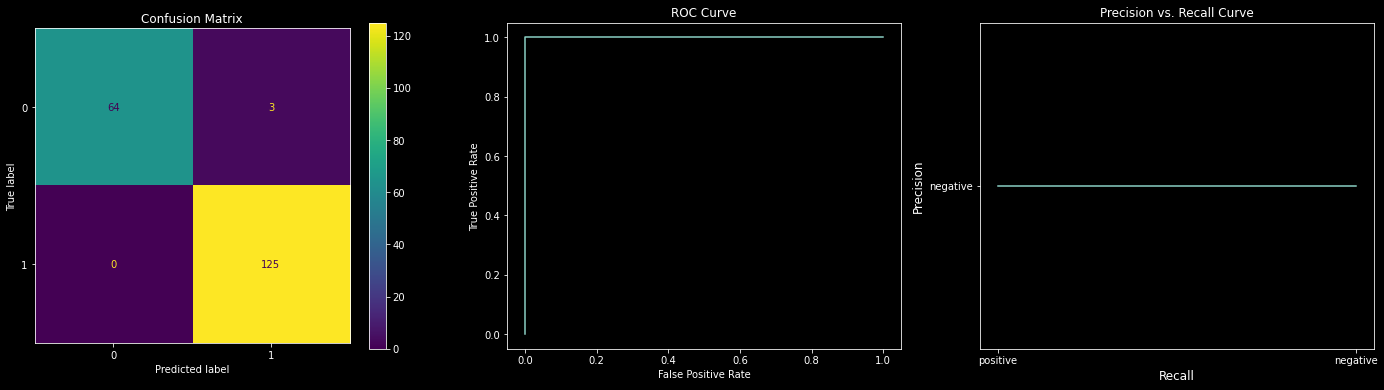

---------------------------------------------
Grid Search 9 Fold 3
{'max_depth': 32, 'max_trees': 150, 'max_features': None, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.9948
Precision (average): 1.0000
Recall (average): 0.6304
F1 Score (positive): 0.9925
F1 Score (negative): 0.9960



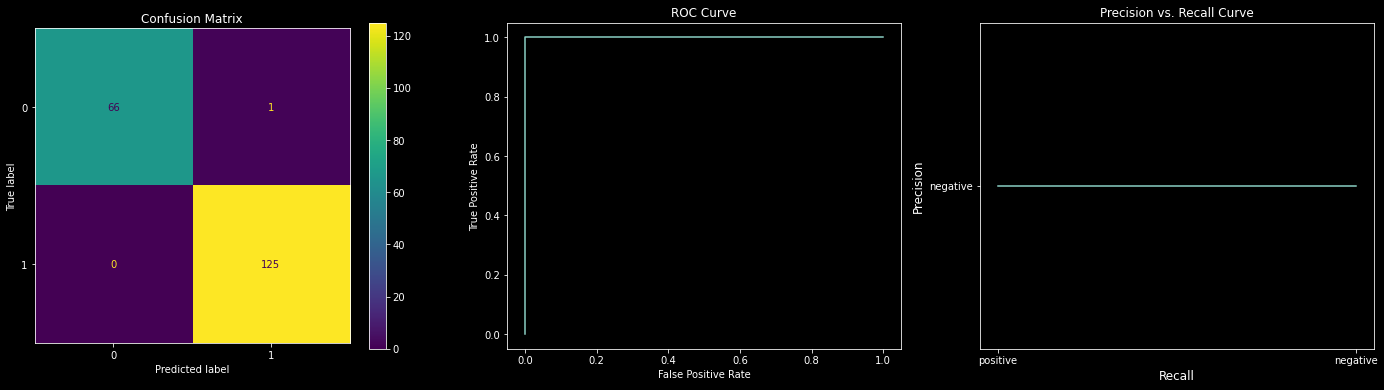

---------------------------------------------
Grid Search 9 Fold 4
{'max_depth': 32, 'max_trees': 150, 'max_features': None, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.9948
Precision (average): 1.0000
Recall (average): 0.6080
F1 Score (positive): 0.9925
F1 Score (negative): 0.9960



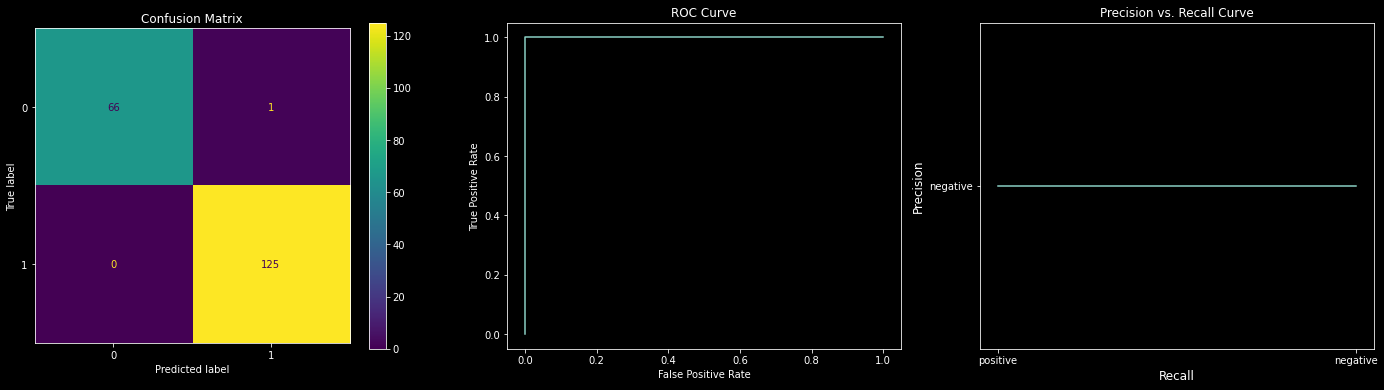

---------------------------------------------
Grid Search 9 Fold 5
{'max_depth': 32, 'max_trees': 150, 'max_features': None, 'learning_rate': 0.001, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 1.0000
Precision (average): 1.0000
Recall (average): 0.7600
F1 Score (positive): 1.0000
F1 Score (negative): 1.0000



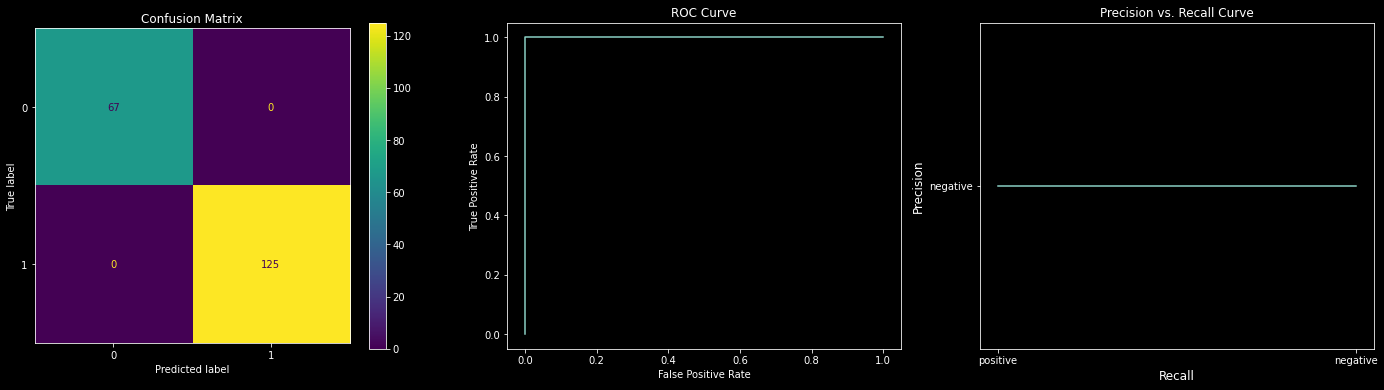

---------------------------------------------
Grid Search 10 Fold 1
{'max_depth': 32, 'max_trees': 150, 'max_features': None, 'learning_rate': 0.01, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.7292
Precision (average): 0.8396
Recall (average): 0.6401
F1 Score (positive): 0.6176
F1 Score (negative): 0.7903



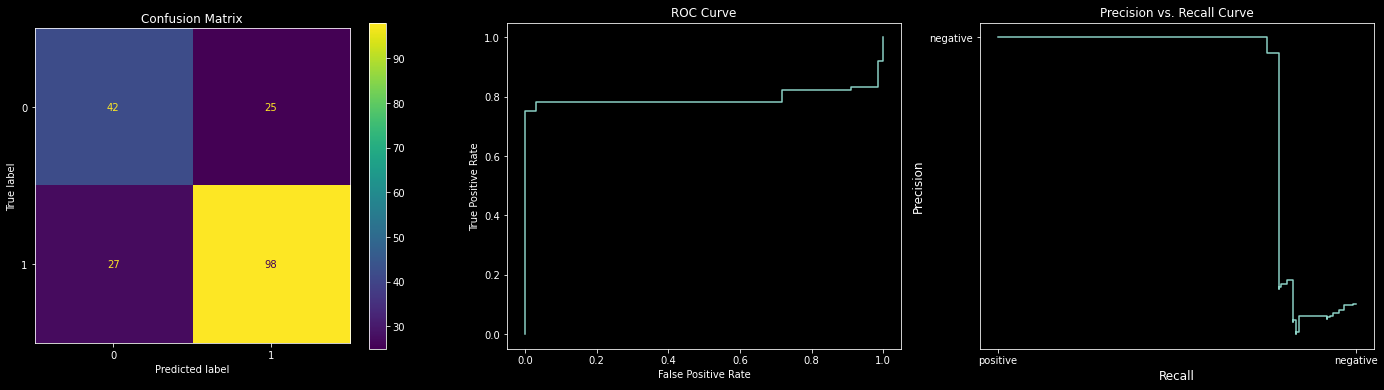

---------------------------------------------
Grid Search 10 Fold 2
{'max_depth': 32, 'max_trees': 150, 'max_features': None, 'learning_rate': 0.01, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.7812
Precision (average): 0.8470
Recall (average): 0.6058
F1 Score (positive): 0.7407
F1 Score (negative): 0.8108



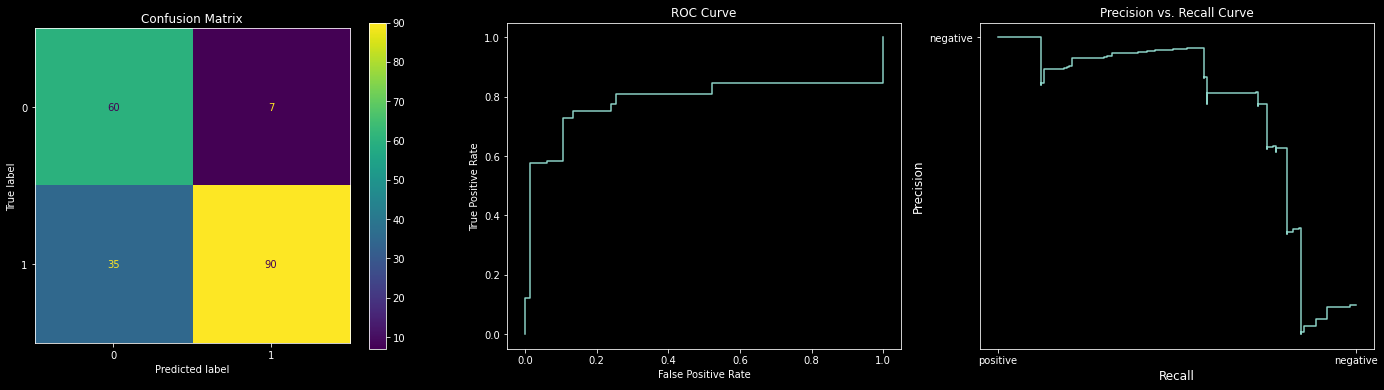

---------------------------------------------
Grid Search 10 Fold 3
{'max_depth': 32, 'max_trees': 150, 'max_features': None, 'learning_rate': 0.01, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.7656
Precision (average): 0.8573
Recall (average): 0.6341
F1 Score (positive): 0.7429
F1 Score (negative): 0.7847



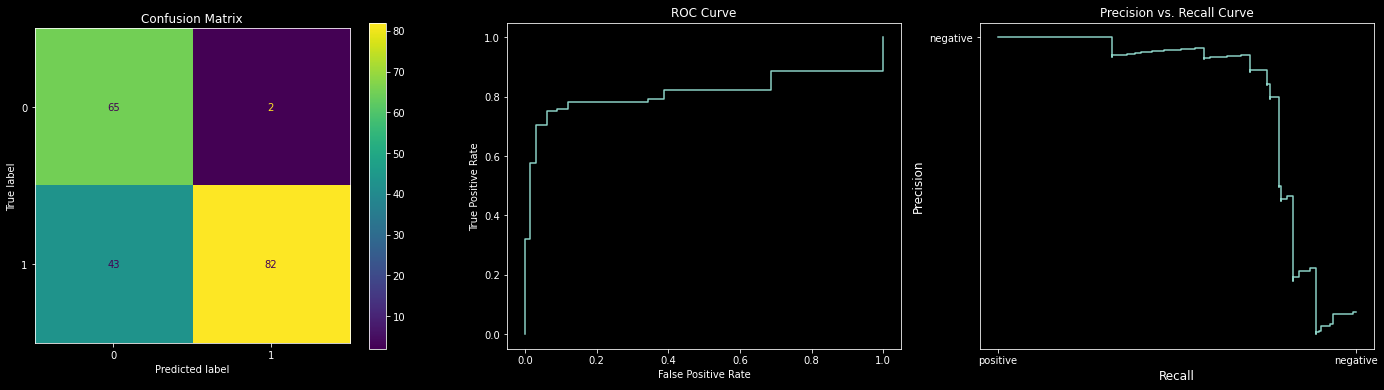

---------------------------------------------
Grid Search 10 Fold 4
{'max_depth': 32, 'max_trees': 150, 'max_features': None, 'learning_rate': 0.01, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.8438
Precision (average): 0.9304
Recall (average): 0.6393
F1 Score (positive): 0.8125
F1 Score (negative): 0.8661



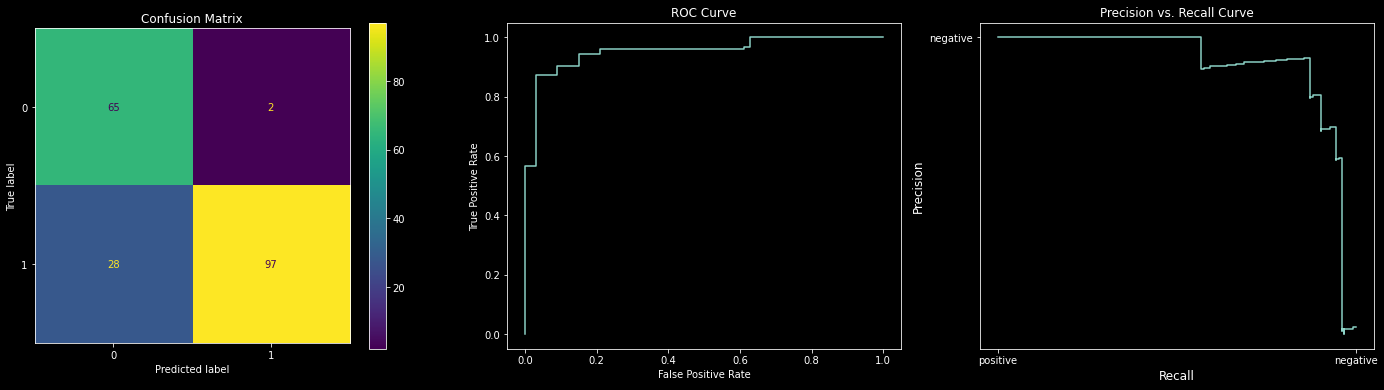

---------------------------------------------
Grid Search 10 Fold 5
{'max_depth': 32, 'max_trees': 150, 'max_features': None, 'learning_rate': 0.01, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.8542
Precision (average): 0.9400
Recall (average): 0.6630
F1 Score (positive): 0.8272
F1 Score (negative): 0.8739



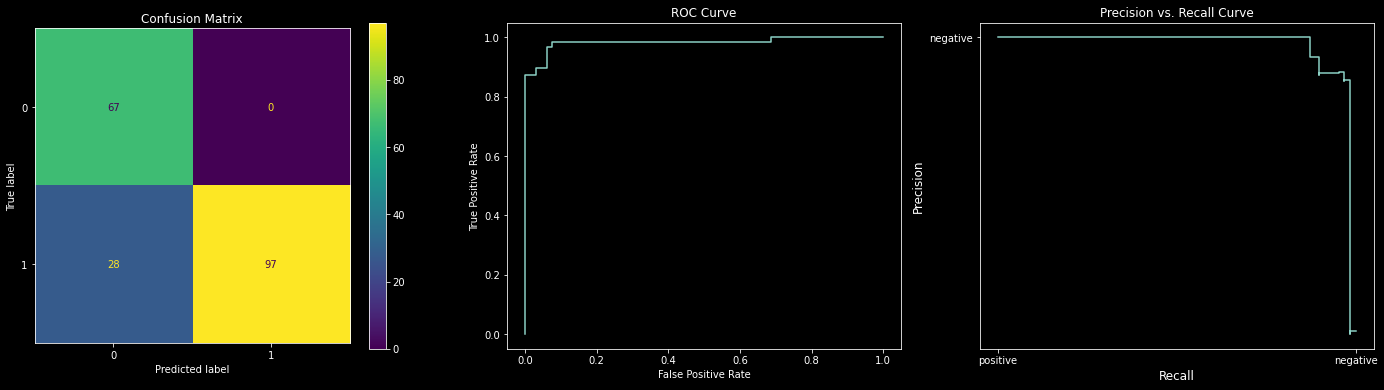

---------------------------------------------
Grid Search 11 Fold 1
{'max_depth': 32, 'max_trees': 150, 'max_features': None, 'learning_rate': 0.1, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.9844
Precision (average): 0.9737
Recall (average): 0.6629
F1 Score (positive): 0.9774
F1 Score (negative): 0.9880



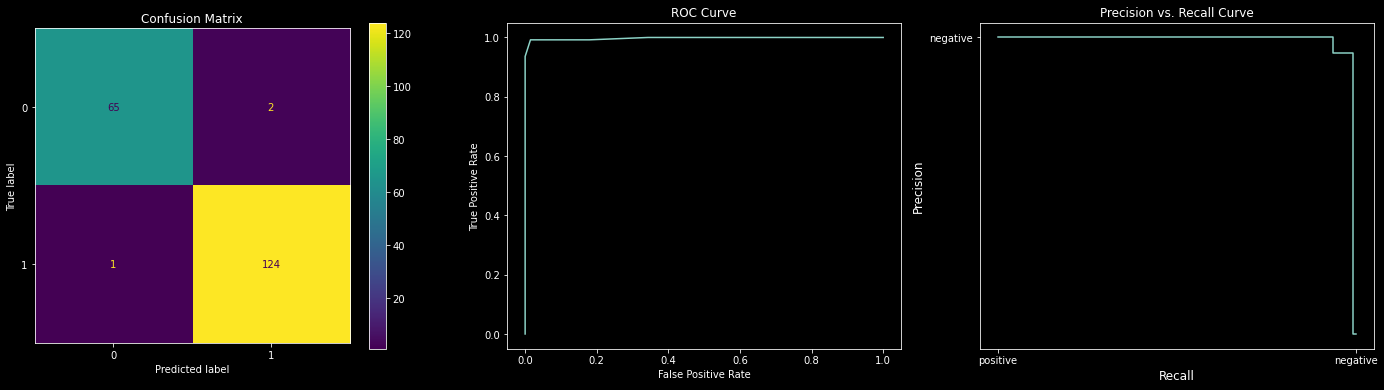

---------------------------------------------
Grid Search 11 Fold 2
{'max_depth': 32, 'max_trees': 150, 'max_features': None, 'learning_rate': 0.1, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.9948
Precision (average): 1.0000
Recall (average): 0.5104
F1 Score (positive): 0.9926
F1 Score (negative): 0.9960



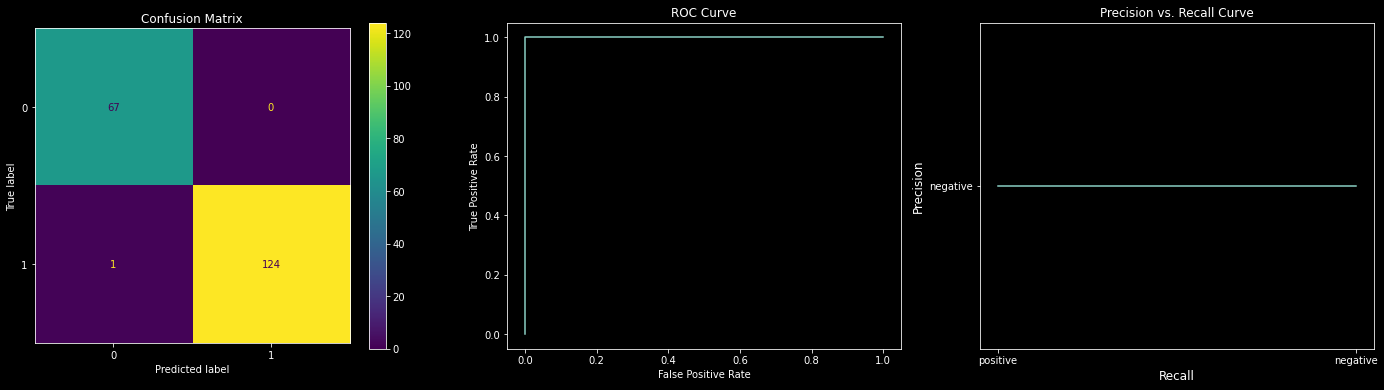

---------------------------------------------
Grid Search 11 Fold 3
{'max_depth': 32, 'max_trees': 150, 'max_features': None, 'learning_rate': 0.1, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 1.0000
Precision (average): 1.0000
Recall (average): 0.5905
F1 Score (positive): 1.0000
F1 Score (negative): 1.0000



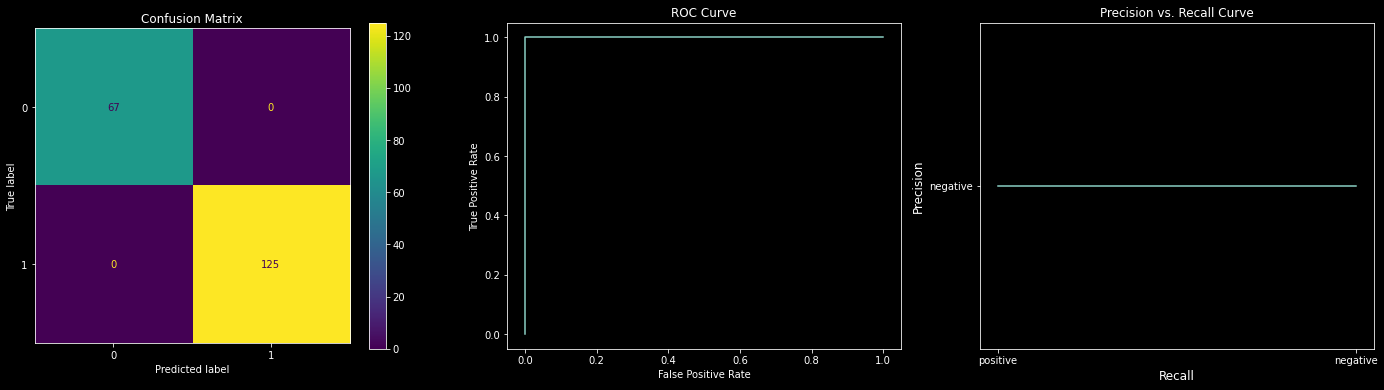

---------------------------------------------
Grid Search 11 Fold 4
{'max_depth': 32, 'max_trees': 150, 'max_features': None, 'learning_rate': 0.1, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 1.0000
Precision (average): 1.0000
Recall (average): 0.5448
F1 Score (positive): 1.0000
F1 Score (negative): 1.0000



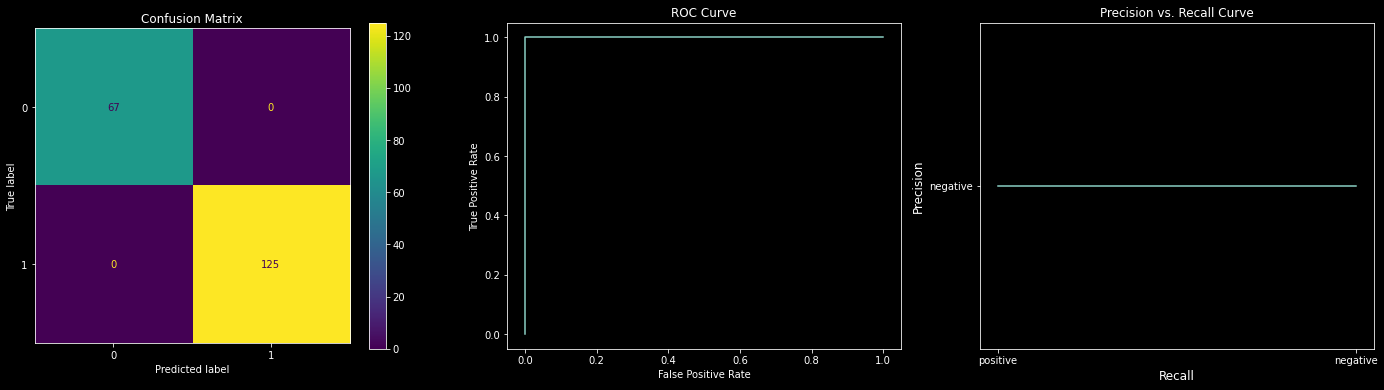

---------------------------------------------
Grid Search 11 Fold 5
{'max_depth': 32, 'max_trees': 150, 'max_features': None, 'learning_rate': 0.1, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.9948
Precision (average): 1.0000
Recall (average): 0.8062
F1 Score (positive): 0.9926
F1 Score (negative): 0.9960



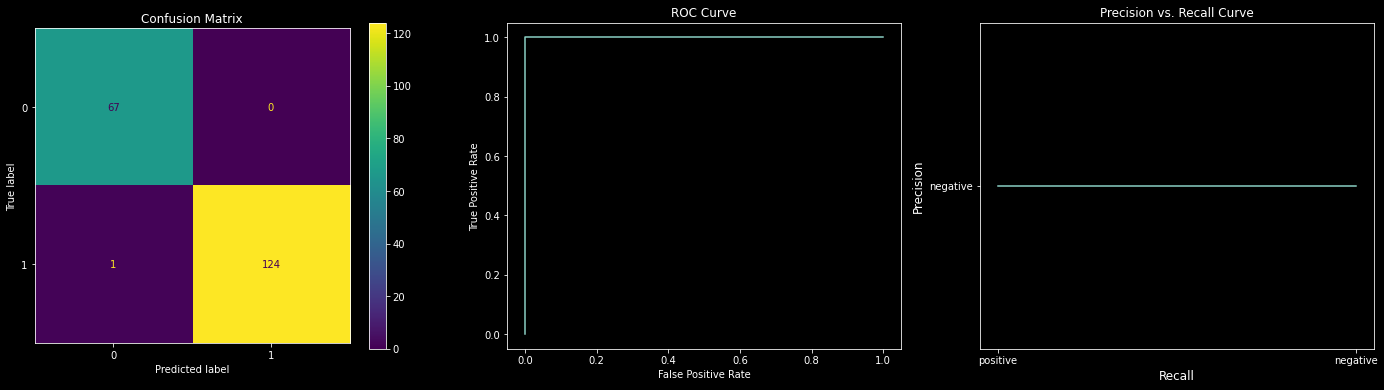

---------------------------------------------
Grid Search 12 Fold 1
{'max_depth': 32, 'max_trees': 150, 'max_features': None, 'learning_rate': 1, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.9844
Precision (average): 0.9290
Recall (average): 0.6553
F1 Score (positive): 0.9774
F1 Score (negative): 0.9880



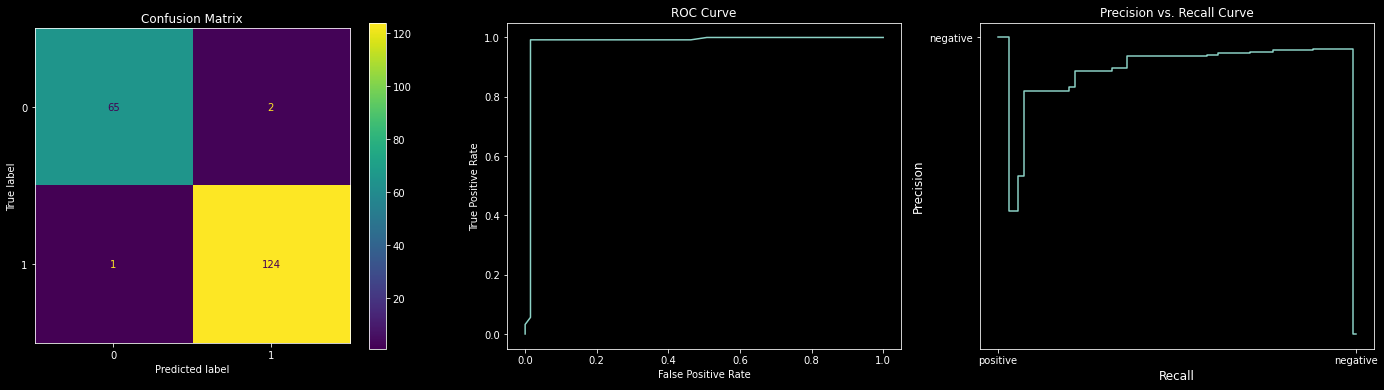

---------------------------------------------
Grid Search 12 Fold 2
{'max_depth': 32, 'max_trees': 150, 'max_features': None, 'learning_rate': 1, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.9948
Precision (average): 1.0000
Recall (average): 0.3940
F1 Score (positive): 0.9926
F1 Score (negative): 0.9960



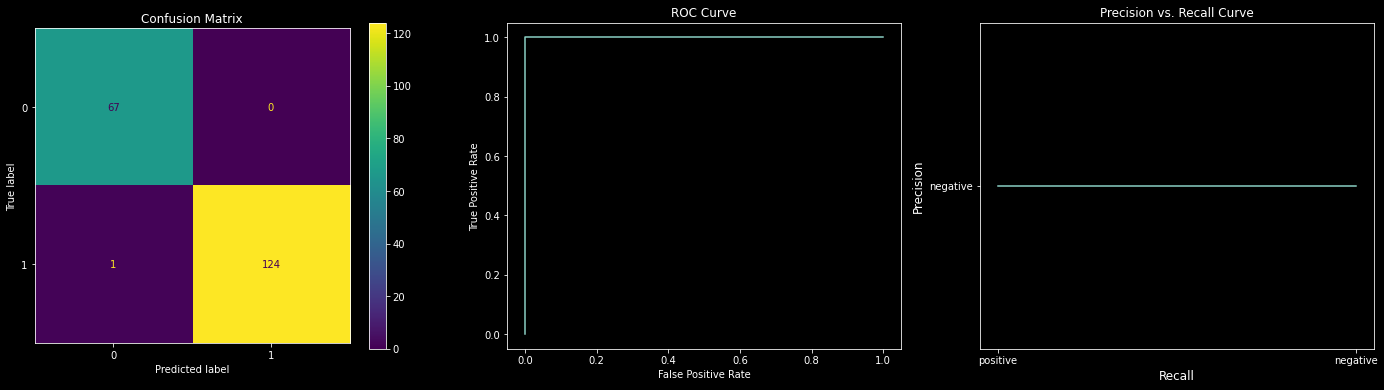

---------------------------------------------
Grid Search 12 Fold 3
{'max_depth': 32, 'max_trees': 150, 'max_features': None, 'learning_rate': 1, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.9792
Precision (average): 1.0000
Recall (average): 0.8200
F1 Score (positive): 0.9710
F1 Score (negative): 0.9837



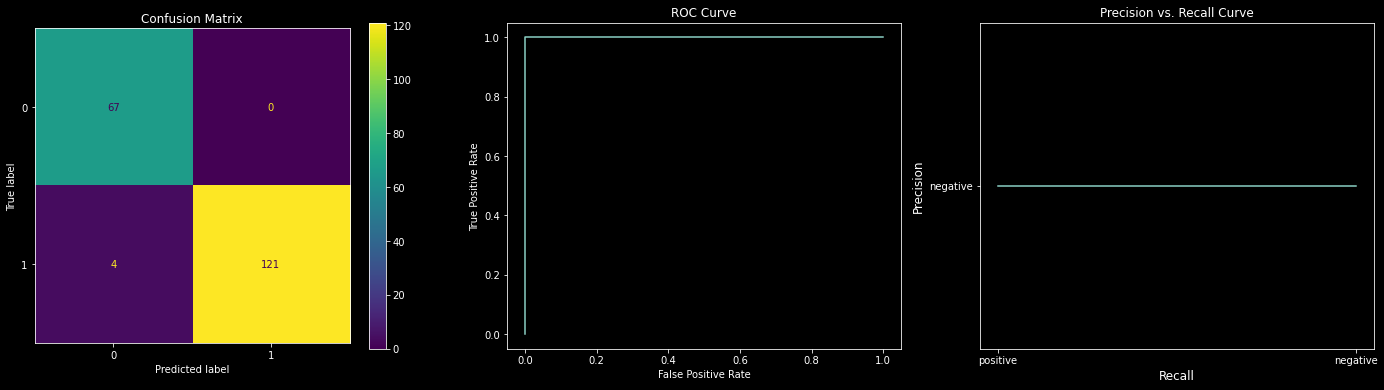

---------------------------------------------
Grid Search 12 Fold 4
{'max_depth': 32, 'max_trees': 150, 'max_features': None, 'learning_rate': 1, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.9844
Precision (average): 1.0000
Recall (average): 0.7904
F1 Score (positive): 0.9781
F1 Score (negative): 0.9879



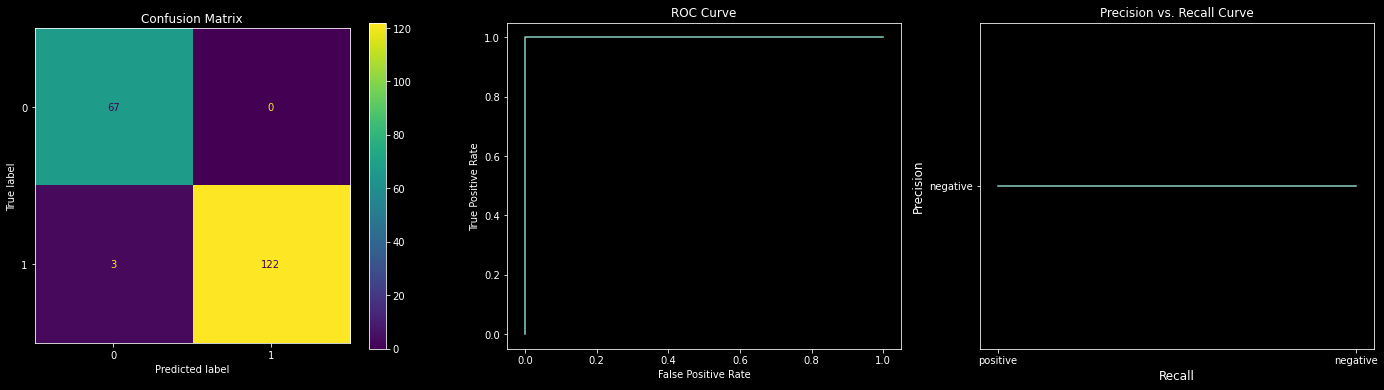

---------------------------------------------
Grid Search 12 Fold 5
{'max_depth': 32, 'max_trees': 150, 'max_features': None, 'learning_rate': 1, 'epsilon': 0.001}

Train Samples: 766; Test Samples: 192
Accuracy: 0.9688
Precision (average): 1.0000
Recall (average): 0.8540
F1 Score (positive): 0.9571
F1 Score (negative): 0.9754



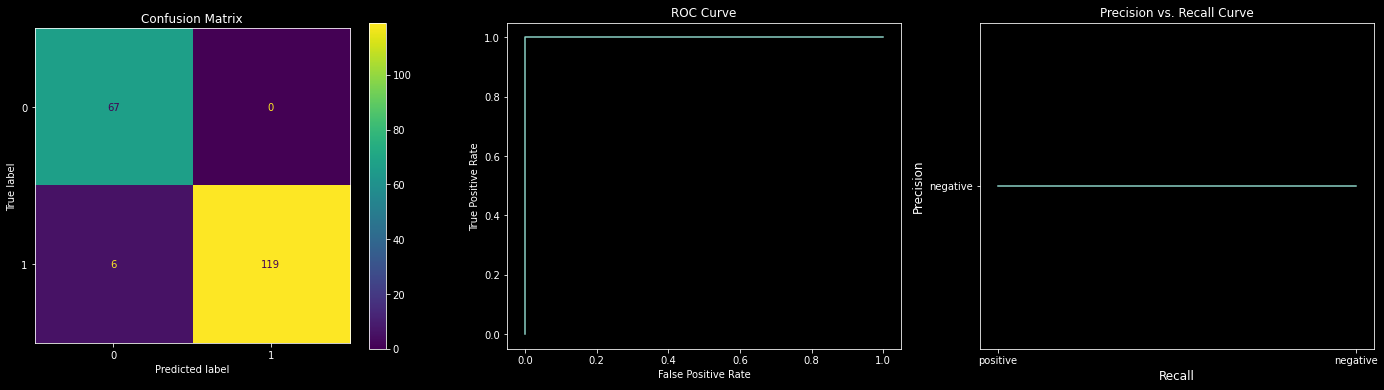

In [43]:
grid_search_evaluate({
    'max_depth': [8, 16, 24, 32],
    'max_trees': [10, 50, 100, 150],
    'max_features': [3, 6, None],
    'learning_rate': [1e-3, 1e-2, 1e-1, 1],
    'epsilon': [1e-3],
})